##### Contents
- [Counter](#Counter)
- [Andor](#Andor)
- [Hamamatsu](#Hamamatsu)
- [Count_Plots](#Count_Plots)
- [Cuts](#Cuts)
- [Loading](#Loading)
- [Retention](#Retention)
- [GOOD logger](#GOOD_Data)
- [Auto Aligner](#Auto_Aligner)
- [TODO](#TODO)
- [Appendix](#Appendix)
- [Settings](#Settings)
- [Copy](#Copy)

In [1]:
%matplotlib notebook
""
import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
from scipy.optimize import curve_fit
from scipy.special import erfc, gamma,gammainc
from scipy.interpolate import interp1d
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product
if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"
sys.path.append(repo_path)
from datetime import datetime,timedelta
import time
from configparser import ConfigParser
import logging
import psycopg2 as PSQL
# local imports
import HamamatsuH5
import AndorH5
import counterh5
from Iterations import Iterations,seed_permute
from PlottingH5 import default_plotting, iterate_plot_2D, expand_iter_array, _fix_nd_indexing, get_var
from FittingH5 import *
from DropRecapture import drop_recapture_MC, get_temp

In [2]:
def plt_subplots(nrows=1, ncols=1,*args,**kwargs):
    """
    Function to wrap plt.subplots and make sure the same block of code can plot many axes and a single axis
    """
    fig,axarr = plt.subplots(nrows,ncols,*args,**kwargs)
    if nrows == 1 and ncols == 1:
        axarr = array([axarr])
    return fig,axarr
    
h5file = h5py.File('results.hdf5',mode='r+')

iterations = Iterations(h5file)
#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()]+1
num_its = len(h5file['iterations'])

#Find independent variable names and values
#indep_vars = DataH5.get_indep_vars(h5file)
#iVars = list(indep_vars.keys())

# map iterations to independent variable values

# iterations = DataH5.make_iterations_df(h5file, iVars)

exp_time = h5file.attrs["start_time"]
exp_day = str(datetime.fromtimestamp(exp_time))[:10]
exp_desc = f"{exp_day}_2VBias_{{}}"

iterations

   iteration  DropTime
0          0       0.0
1          1      12.5
2          2      25.0
3          3      37.5
4          4      50.0
5          5      62.5
6          6      75.0
7          7      87.5
8          8     100.0
9          9     112.5
10        10     125.0
11        11     137.5
12        12     150.0
13        13     162.5
14        14     175.0
15        15     187.5
16        16     200.0
17        17     212.5
18        18     225.0
19        19     237.5
20        20     250.0

# Counter

In [3]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])  # Standard
shots_per_measurement = 2  # Single RO
counter_bin, counter_shot = counterh5.load_data(h5file, drop_bins, ro_bins, shots=shots_per_measurement)
count_data = counter_shot

## Plot data bins as bar graphs

In [ ]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} bin bar graphs. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(row["iteration"])
        # bin shot 0 and shot 1 the same way
        for shot in range(shots_per_measurement):
            axarr[iteration].bar(range(ro_bins),counter_bin.mean(1)[iteration,shot,drop_bins:],alpha=0.5,label = f"shot {shot}")
        axarr[iteration].set_ylabel("Average counts in bin")
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
    fig.tight_layout()
    fig.show()

In [ ]:
func = lambda x,a,T,o : exp_decay(x,a,T)+o
guess = [
    25.0,
    12.0,
    5
]
args = ["Amplitude", "Decay Time (RO_bins)", "Offset"]
title = "\nDecay Time {2} = {0[1]:.2f} $\pm$ {1[1]:.2f} bins"

popts = zeros((len(guess),len(iterations),shots_per_measurement),dtype=float)
perrs = zeros(popts.shape,dtype=float)


fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for iteration, row in iterations.iterrows():
    iteration = int(iteration)
    # bin shot 0 and shot 1 the same way
    tit = str(row)
    shots_to_fit = 1 # shots_per_measurement
    for shot in range(shots_to_fit):
        xdat = arange(0,ro_bins,1)
        ydat = counter_bin.mean(1)[iteration,shot,drop_bins:]
        yerr = counter_bin.std(1)[iteration,shot,drop_bins:]/sqrt(measurements)
        popt, pcov = curve_fit(func,xdata=xdat,ydata=ydat,sigma=yerr,p0=guess)
        perr = sqrt(diag(pcov))
        
        popts[:, iteration, shot] = popt
        perrs[:, iteration, shot] = perr
        
        xlin = linspace(min(xdat),max(xdat),1000)
        axarr[iteration].errorbar(xdat, ydat, yerr=yerr, fmt=".", label = f"data shot {shot}")
        axarr[iteration].plot(xlin, func(xlin,*popt), label = f"fit shot {shot}")
        
        tit += title.format(popt, perr, shot)
    axarr[iteration].set_ylabel("Average counts in bin")
    axarr[iteration].legend()
    axarr[iteration].set_title(tit)
fig.tight_layout()
fig.show()

for i, arg in enumerate(args):
    default_plotting(iterations, popts[i,...], perrs[i,...], shots = shots_to_fit, description= arg, fmt = ".")

In [ ]:
default_plotting(iterations, popts[0,...]+popts[2,...], perrs[0,...]+perrs[2,...], shots = shots_to_fit, description= "max C", fmt = ".")

To analyze count data go to:
- [Count_Plots](#Count_Plots)

# Andor

In [ ]:
width, height = h5file['/settings/experiment/Andors/motors/motor0/camera/subimage_size'][()]
roi = HamamatsuH5.HMROI(width,height)
''',dic = {
    "left" : 18,
    "right" : 23,
    "top" : 18,
    "bottom" : 23}
    )'''
andor_pix = AndorH5.load_data(h5file,roi)[:,:-1,...]# ignore the last measurement, is sometimes just 0

andor_counts = andor_pix.sum(3).sum(3)
count_data = andor_counts
shots_per_measurement = 1

In [ ]:
#Plot number of pixels which are above a cutoff
cutoff=0.65e3
cut_pix = andor_pix > cutoff
pass_frac = cut_pix.sum(3).sum(3)/(andor_pix.shape[-1]*andor_pix.shape[-2])
count_data = pass_frac
fig, axarr = default_plotting(iterations,count_data.mean(1),count_data.std(1)/sqrt(measurements-1),shots_per_measurement,description="Average Fraction of pixels above a cuttoff",figsize = (8,7))
fig.savefig(exp_desc.format("2DRaw"))
iterations.load_dependent_variables("Ryd_1190_frequency")

In [ ]:
# Plot MOT data as mean counts in ROI
count_data = andor_pix.mean(3).mean(3)
fig, axarr = default_plotting(
    iterations,count_data.mean(1),
    count_data.std(1)/sqrt(measurements-1),
    shots_per_measurement,
    description="Average Fraction of pixels above a cuttoff",
    figsize = (8,7)
)
fig.savefig(exp_desc.format("2DRaw"))
iterations.load_dependent_variables("Ryd_1190_frequency")

In [ ]:
rabi = False

# Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a, o: lorenz(x, x0, fwhm, -abs(a), o)
guess = [
    27,
    2.5,
    -50000,
    6000
]
title = "MOT Depletion Spectroscopy\nx0 = {0[0]:.2f} $\pm$ {1[0]:.3f}(MHz)\nFWHM = {0[1]:.2f} $\pm$ {1[1]:.3f}(MHz)"
unit = "MHz"

'''#Quad Lorenzian
d1 = 8.5   
d2 = 10  
func =  lambda x, x0, d1, d2, d3, fwhm, a1, a2, a3, a4, o, m: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0+abs(d1), fwhm, -abs(a2), 0) + lorenz(x, x0+abs(d1)+abs(d2), fwhm, -abs(a3), 0) + lorenz(x, x0+abs(d1)+abs(d2)+abs(d3), fwhm, -abs(a4), 0) + o + m * x
guess =  [256, 10, 13, 28, 1.5, -0.20, -0.10,-0.10, -20, 0.75, -0.1]
guesses = [
    [165, 10, 10, 15, 1.5, -0.20, -0.10,-0.10, -20, 0.75, -0.1],
    [169, 10, 10, 15, 1.5, -0.20, -0.10,-0.10, -20, 0.75, -0.1],
    [172, 10, 10, 15, 1.5, -0.20, -0.10,-0.10, -20, 0.75, -0.1],
]
g_split = [3,4]

arg_names = ["Mean 1 (MHz)", "Splitting 1 (MHz)", "Splitting 2 (MHz)", "Splitting 3 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Amplitude 4", "Offset", "Slope (MHz^-1)"]
# arg_names = ["Mean 1 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Offset"]
# title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\n" + f"d1 = {d1} MHz (Hardcoded)\nd2 = {d2} MHz (Hardcoded)"
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\nd1 = {0[1]:.2f} $\pm$ {1[1]:.2f} MHz \nd2 = {0[2]:.2f} $\pm$ {1[2]:.2f} MHz\nd3 = {0[3]:.2f} $\pm$ {1[3]:.2f} MHz"
unit = "MHz" '''



'''# Double Lorenzian
func =  lambda x, x01, x02, fwhm, a, o: lorenz(x, x01, fwhm, -abs(a), 0) + lorenz(x, x02, fwhm, -abs(a), 0) + o
 guess = [
    50,
    65,
    6,
    -1000,
    6700
]
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nx02 = {0[1]:.4e} $\pm$ {1[1]:.4e}(MHz)"
unit = "MHz" # '''


'''
# Rapidly Decaying Rabi Oscillations
func = lambda t, freq, amp, offset, tau : 1/2*(amp*cos(2*pi*freq*t)*exp(-t/tau)+1)+offset
guess = [
    0.5,
    0.4,
    0.3,
    1.0
]
title = "Decaying Oscillation\n$\Omega$ = 2$\pi$x{0[0]:.2e} $\pm$ {1[0]:.2e}MHz\nT = {0[3]:.2e} $\pm$ {1[3]:.2e}uS"
unit = "uS"
rabi = True
'''

'''# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, 2*pi*freq, amp, off, phi = pi)
guess = [
    16.0,
    0.6,
    0.05
]
title = "Microwave Rabi Oscillation\n$\Omega = 2\pi x {0[0]:.1f}KHz \pm 2\pi x {0[0]:.1f}KHz$"
unit = "ms"
rabi = True'''


'''# 1-exp(-t/T)
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
unit = "ms"'''

'''
# a*exp(-t/T)
func = lambda x, a, T, o: exp_decay(x,a,T)+o
guess = [
    0.8,
    3,
    0.1
]
title = "T = {0[1]:.1f}ms $\pm$ {1[1]:.1f}ms"
unit= "ms"
'''
'''
#gauss
func = gaussian
guess = [
    0.1,
    1,
    0.5
]
title = "Gauss\n mu = {0[0]:.3f} $\pm$ {1[0]:.3f}"
unit = "V"
'''

xdat = iterations[iterations.ivars[0]]
xdat = iterations["Ryd_1190_frequency"]
ydat = count_data.mean(1)[:,0]
ystd = count_data.std(1)[:,0]/sqrt(measurements-1)

er = False
try:
    popt, pcov = curve_fit(func, xdat, ydat, sigma=None, p0 = guess)
    perr = sqrt(diag(pcov))
except RuntimeError:
    popt = zeros(len(guess))
    perr = zeros(len(guess))
    print("Fit Failed")
    er = True

#unit = "us"
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(xdat,ydat,ystd,fmt=".")
xlin = linspace(min(xdat),max(xdat),1000)
if not er:
    ax.plot(xlin, func(xlin,*popt))
else:
    ax.plot(xlin, func(xlin,*guess))
if rabi:
    title += f"\n$t_\pi/2 = {1/(2*popt[0]):.4f}ms$"
ax.set_title(title.format(popt,perr))
#ax.set_title(f"T = {popt[1]:.3f}ms $\pm$ {perr[1]:.3f}ms")
#ax.set_title(f"Microwave Rabi Oscillation\n$\Omega = 2\pi x {popt[0]/(2*pi):.1f}KHz \pm 2\pi x {perr[0]/(2*pi):.1f}KHz$\n$t_\pi/2 = {pi/popt[0]:.4f}ms$")
ax.set_ylabel("Fraction of Pixels above threshold")
ax.set_xlabel(f"{iterations.ivars[0]}({unit})")
fig.tight_layout()
fig.savefig("Mot_depletion_11242021.png")
fig.show()

## Plot 2D scan iteratively

In [ ]:
fig, axarr = iterate_plot_2D(
    iterations,
    count_data.mean(1),
    count_data.std(1)/sqrt(measurements-1),
    "Ryd_1190_frequency",
    iterations.ivars[0],
    "",
    1,
    fmt="-"
)
fig.savefig("baslkd.png")

## Fit the plot 2D scan iteratively

In [ ]:
guesses = None
g_split = None
'''
# Gaussian Functions
func = lambda x, x0, std, a : gaussian(x,x0,std,a) + 0.8
guess = [
    7.1,
    0.02,
    -0.5
]
arg_names = ["Mean (mm)", "STD (mm)", "Amplitude"]
title = "Gaussian Dip x0 = {0[0]:.3f} $\pm$ {1[0]:.3f}"
'''

'''
# Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a, o: lorenz(x, x0, fwhm, -abs(a), o)
guess = [38,4,-40,7]# None
guesses = [
    [30, 4.0, -40, 7],
    [50, 4.0, -40, 7],
]
g_split = [4]
arg_names = ["Mean (MHz)", "FWHM (MHz)", "Amplitude", "Offset"]
title = "Rydberg MOT depletion Spectroscopy\nx0 = {0[0]:.2f} $\pm$ {1[0]:.2f}(MHz)\nFWHM = {0[1]:.2f} $\pm$ {1[1]:.2f}(MHz)"
'''

'''# Double Lorenzian
func =  lambda x, x01, x02, fwhm, a1, a2, o: lorenz(x, x01, fwhm, -abs(a1), 0) + lorenz(x, x02, fwhm, -abs(a2), 0) + o
# guess = [
#    51,
#    75,
#    4.0,
#    -0.6,
#    -0.4,
#    0.87,
#]
guess = None
guesses = [
    [32.2,33,2.4,-4,-4,5.2], # 0, -30
    [33.6,35,2.4,-4,-4,5.2], # 1, -29
    [33.5,36,2.4,-4,-4,5.2], # 2, -28
    [35.5,38.8,2.4,-4,-4,5.2], # 3, -27
    [37,42,2.4,-4,-4,5.2], # 4, -26
    [38,44,2.4,-4,-4,5.2], # 5, -25
    [28.5+100,0,2.4,-4,-4,5.2], # 6, -24
    [28.5+100,0,2.4,-4,-4,5.2], # 7, -23
    [28.5+100,0,2.4,-4,-4,5.2], # 8, -22
    [28.5+100,0,2.4,-4,-4,5.2], # 9, -20
    [28.5+100,0,2.4,-4,-4,5.2], # 10, -19
    [28.5+100,0,2.4,-4,-4,5.2], # 11, -18   
    [28.5+100,0,2.4,-4,-4,5.2], # 11, -18   
]
g_split = range(1,12)
arg_names = ["Mean 1 (MHz)", "Mean 2 (MHz)", "FWHM (MHz)", "Amplitude"]
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.1f} $\pm$ {1[0]:.2f}(MHz)\nx02 = {0[1]:.2f} $\pm$ {1[1]:.3f}(MHz)"
unit = "MHz"'''

'''# Triple Lorenzian
# d1 = 8.5  # MHz
# d2 = 15.5 # MHz
func =  lambda x, x0, d1, d2, fwhm, a1, a2, a3, o: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0 + abs(d1), fwhm, -abs(a2), 0) + lorenz(x, x0 + abs(d1) + abs(d2), fwhm, -abs(a3), 0) + o
# func =  lambda x, x0, fwhm, a1, a2, a3, o: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0 + d1, fwhm, -abs(a2), 0) + lorenz(x, x0 + d2, fwhm, -abs(a3), 0) + o
guess = None
guesses = [
    [38, 0, 6, 2.5, -2, -1, -2, 5.5], # 0, -25
    [42, 0, 7, 2.5, -2, -1, -2, 5.5], # 1, -24
    [44, 0, 8, 2.5, -2, -1, -2, 5.5], # 2, -23
    [47.97, 1, 8.47, 2.5, -4, -4, -4, 5.5], # 3, -22
    [52.51, 3, 9, 2.5, -4, -4, -4, 5.5], # 4, -21
    [57, 4, 8, 2.5, -2, -1, -2, 5.5], # 5, -20
    [64, 5, 8, 2.5, -2, -1, -2, 5.5], # 6, -19
    [72, 7, 8, 2.5, -2, -1, -2, 5.5], # 7, -18
]
g_split = range(1,8)

arg_names = ["Mean 1 (MHz)", "Splitting 1 (MHz)", "Splitting 2 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Offset"]
# arg_names = ["Mean 1 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Offset"]
# title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\n" + f"d1 = {d1} MHz (Hardcoded)\nd2 = {d2} MHz (Hardcoded)"
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\nd1 = {0[1]:.2f} $\pm$ {1[1]:.2f} MHz \nd2 = {0[2]:.2f} $\pm$ {1[2]:.2f} MHz"
unit = "MHz"
'''
# Quad Lorenzian
d1 = 8.5   
d2 = 10  
func =  lambda x, x0, d1, d2, d3, fwhm, a1, a2, a3, a4, o, m: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0+abs(d1), fwhm, -abs(a2), 0) + lorenz(x, x0+abs(d1)+abs(d2), fwhm, -abs(a3), 0) + lorenz(x, x0+abs(d1)+abs(d2)+abs(d3), fwhm, -abs(a4), 0) + o + m * x
# func =  lambda x, x0, fwhm, a1, a2, a3, o: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0 + d1, fwhm, -abs(a2), 0) + lorenz(x, x0 + d2, fwhm, -abs(a3), 0) + o
guess = None # [202, 12, 9, 14, 3.0, -4, -4, -4, -4, 6, 0]  # 0, -10

guesses = [
    [365, 11.04, 18.42, 28.15, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -3
    [360, 11.34, 18.6, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -3
    [355.5, 11.7, 19.1, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -2
    [352.1, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 1, -1 #no good
    [350.7, 12.1, 19.7, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 0
    [349.6, 12.2, 20.1, 29.4, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 1
    [348.8, 12, 19.4, 27.6, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 2 #no good
    [349.5, 12.2, 19.6, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 3
    [350.8, 11.6, 19.5, 29.1, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 4 #no good 
    [353, 11, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 5     #no good 
    [356, 11.4, 18.5, 28.8, 2.0, -2, -2, -2, -2, 5.0, 0],  
]

'''guesses = [
    [364, 12.1, 18.1, 28.8, 2.0, -2, -2, -2, -2, 5.0, 0],
    [360, 12.1, 18.1, 28.8, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -3
    [357, 12.1, 18.1, 28.8, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -3
    [355, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -2
    [350, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 1, -1
    [345, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 0
    [340, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 1
    [345, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 2
    [345, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 3
    [345, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 4
    [356, 11.6, 17.0, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 5    
]'''
g_split = range(1,len(guesses)+1)

arg_names = ["Mean 1 (MHz)", "Splitting 1 (MHz)", "Splitting 2 (MHz)", "Splitting 3 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Amplitude 4", "Offset", "Slope (MHz^-1)"]
# arg_names = ["Mean 1 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Offset"]
# title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\n" + f"d1 = {d1} MHz (Hardcoded)\nd2 = {d2} MHz (Hardcoded)"
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\nd1 = {0[1]:.2f} $\pm$ {1[1]:.2f} MHz \nd2 = {0[2]:.2f} $\pm$ {1[2]:.2f} MHz\nd3 = {0[3]:.2f} $\pm$ {1[3]:.2f} MHz"
unit = "MHz"
'''
# Quint Lorenzian
func =  lambda x, x0, d1, d2, d3, d4, fwhm, a1, a2, a3, a4, a5, o, m: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0+abs(d1), fwhm, -abs(a2), 0) + lorenz(x, x0+abs(d1)+abs(d2), fwhm, -abs(a3), 0) + lorenz(x, x0+abs(d1)+abs(d2)+abs(d3), fwhm, -abs(a4), 0) + lorenz(x, x0+abs(d1)+abs(d2)+abs(d3)+abs(d4), fwhm, -abs(a5), 0) + o + m * x
# func =  lambda x, x0, fwhm, a1, a2, a3, o: lorenz(x, x0, fwhm, -abs(a1), 0) + lorenz(x, x0 + d1, fwhm, -abs(a2), 0) + lorenz(x, x0 + d2, fwhm, -abs(a3), 0) + o
guess = None
guesses = [
    [258, 11, 15, 10, 20, 1.5, -0.26, -0.10,-0.10, -0.20, -.20, 0.75, -0.1],
    [250, 11, 15, 10, 20, 1.5, -0.26, -0.10,-0.10, -0.20, -.20, 0.75, -0.1],
    [258, 11, 15, 10, 20, 1.5, -0.26, -0.10,-0.10, -0.20, -.20, 0.75, -0.1],
    [265, 11, 15, 10, 20, 1.5, -0.26, -0.10,-0.10, -0.20, -.20, 0.75, -0.1],
    [270, 11, 15, 10, 20, 1.5, -0.26, -0.10,-0.10, -0.20, -.20, 0.75, -0.1]
]
g_split = [2,7,8,9]

arg_names = ["Mean 1 (MHz)", "Splitting 1 (MHz)", "Splitting 2 (MHz)", "Splitting 3 (MHz)", "Splitting 4 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Amplitude 4", "Amplitude 5", "Offset", "Slope (MHz^-1)"]
# arg_names = ["Mean 1 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude 2", "Amplitude 3", "Offset"]
# title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\n" + f"d1 = {d1} MHz (Hardcoded)\nd2 = {d2} MHz (Hardcoded)"
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f} MHz\nd1 = {0[1]:.2f} $\pm$ {1[1]:.2f} MHz \nd2 = {0[2]:.2f} $\pm$ {1[2]:.2f} MHz\nd3 = {0[3]:.2f} $\pm$ {1[3]:.2f} MHz\nd4 = {0[4]:.2f} $\pm$ {1[4]:.2f} MHz"
unit = "MHz"
'''

'''# Double Lorenzian - spacing Param
split_hardcode = 16  # MHz
func =  lambda x, x01, fwhm, a, o: lorenz(x, x01, fwhm, -abs(a), 0) + lorenz(x, x01+split_hardcode, fwhm, -abs(a), 0) + o
guess =[
    45,
    3.0,
    0.5,
    0.87,
]
arg_names = ["Mean 1 (MHz)", "FWHM (MHz)", "Amplitude", "Offset"]
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.2f} $\pm$ {1[0]:.2f}MHz\n"
title += f"Splitting = {split_hardcode} MHz (hardcoded)"
unit = "MHz"
'''

'''# Tripple Lorenzian
func =  lambda x, x01, x02, x03, fwhm, a1,a2, o: lorenz(x, x01, fwhm, -abs(a1), 0) + lorenz(x, x02, fwhm, -abs(a2), 0) +lorenz(x, x03, fwhm, -abs(a1), 0) + o
guess = [
    50,
    58,
    65,
    3.0,
    -0.1,
    -0.05,
    0.90,
]
arg_names = ["Mean 1 (MHz)", "Mean 2 (MHz)", "Mean 3 (MHz)", "FWHM (MHz)", "Amplitude 1", "Amplitude2 ", "Offset"]
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nx02 = {0[1]:.4e} $\pm$ {1[1]:.4e}(MHz)\nx03 = {0[2]:.4e} $\pm$ {1[2]:.4e}(MHz)\n"
unit = "MHz"'''

'''
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
'''

'''
# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, freq, amp, off, phi = pi/2)
guess = [
    pi*30,
    0.5,
    0.05
]
title = "$\Omega = 2pi x {0[0]:.1f}KHz \pm {1[0]:.1f}KHz$"
arg_names = ["Omega", "Amplitude", "Offset"]
'''

'''#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]'''

y_scale = 1e-3

x_ivar = iterations.ivars[1]
x_ivar = "Ryd_1190_frequency"
y_ivar = iterations.ivars[0]
shots = 1
#fit data iteratively
popts, perrs = iterate_fit_2D(
    iterations,
    count_data.mean(1)[:,0]*y_scale,
    func,
    guess=guess,
    guesses=guesses,
    g_split=g_split,
    data_error = count_data.std(1)[:,0]/sqrt(measurements-1)*y_scale,
    x_var = x_ivar,
    it_var = y_ivar,
    shots = shots
)
#plot the raw data
fig, axarr = iterate_plot_2D(
    iterations,
    count_data.mean(1)[:,0],
    count_data.std(1)[:,0]/sqrt(measurements-1),
    x_ivar,
    y_ivar,
    "Average Fraction of pixels above a cuttoff",
    shots,
    fmt="."
)
#plot the fitted curves
for i, ax in enumerate(axarr):
    for shot in range(shots):
        if x_ivar in iterations.ivars:
            xlin = linspace(min(iterations[x_ivar]),max(iterations[x_ivar]),1000)
        else:
            y_var_ind = [i for i, v in enumerate(iterations.vars) if v == y_ivar][0]
            x_indep = iterations.ivars[not y_var_ind]
            x_len = len(iterations.independent_variables[x_indep])
            x_var = x_ivar
            if y_var_ind:
                x_vals = iterations[x_var][i*x_len:(i+1)*x_len]
            else:
                x_vals = iterations[x_var][i::len(iterations.independent_variables[y_ivar])]
#            x_vals = iterations[x_ivar][i * x_len:(i + 1) * x_len]
            xlin = linspace(min(x_vals), max(x_vals), 1000)
        ax.plot(xlin,func(xlin,*popts[i,shot])/y_scale,label="Fit")
        #ax.plot(xlin, func(xlin,*guesses[i])/y_scale,label="Guess")  # This is a bad idea 90% of the time
        #ax.plot(xlin, func(xlin,*guess)/y_scale,label="Guess")  # This is a bad idea 90% of the time
    ax.set_title(f"{y_ivar} = {iterations.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0],perrs[i,0]))
    ax.legend()
fig.tight_layout()
fig.show()
fig.savefig(exp_desc.format("ResonanceFits"))


# Plot some results of the above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    y_vals = [fit_val if perrs[j,0,i] < 5*median(perrs[:,0,i]) else float("NaN") for j, fit_val in enumerate(popts[:,0,i])]
    y_error = [p_error if perrs[j,0,i] < 5*median(perrs[:,0,i]) else float("NaN") for j, p_error in enumerate(perrs[:,0,i])]
    ax.errorbar(iterations.independent_variables[y_ivar], y_vals, yerr = y_error)
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.show()

In [ ]:
len(guesses)
len(iterations.independent_variables["RydDressPower"])

In [ ]:
guesses = [
    [365, 11.04, 18.42, 28.15, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -3
    [360, 11.34, 18.6, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -3
    [355.5, 11.7, 19.1, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, -2
    [352.1, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 1, -1 #no good
    [350.7, 12.1, 19.7, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 0
    [349.6, 12.2, 20.1, 29.4, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 1
    [338.8, 10.3, 19.4, 27.6, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 2 #no good
    [349.5, 12.2, 19.6, 29.0, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 3
    [350.8, 11.6, 19.5, 29.1, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 4 #no good 
    [347.7, 11.6, 19.5, 27.65, 2.0, -2, -2, -2, -2, 5.0, 0],  # 0, 5     #no good 
    [356, 11.4, 18.5, 28.8, 2.0, -2, -2, -2, -2, 5.0, 0],  
]

In [ ]:
iterations.ivars

In [ ]:
n_means = 4
acdc = "dc"

means = zeros((n_means, popts.shape[0]),dtype=float)
dmeans = zeros((n_means, popts.shape[0]),dtype=float)
for i in range(n_means):
    # fi
    fit_vals = array([abs(fit_val) if perrs[j,0,i] < 5*median(perrs[:,0,i]) else NaN for j, fit_val in enumerate(popts[:,0,i])])
    fit_errs = array([fit_err if perrs[j,0,i] < 5*median(perrs[:,0,i]) else NaN for j, fit_err in enumerate(perrs[:,0,i])]) 
    if i == 0:
        means[i] = fit_vals
        dmeans[i] = fit_errs
    else:
        means[i] = means[i-1] + fit_vals
        dmeans[i] = sqrt(dmeans[i-1]**2+fit_errs**2)  # add errors in quadrature
fig,ax = plt.subplots(1,1)
for i in range(n_means):
    ax.errorbar(iterations.independent_variables[y_ivar],means[i], yerr=dmeans[i],fmt=".",label=f"$\mu_{i}$")
ax.set_xlabel(y_ivar)
ax.set_ylabel("Resonance at 1190nm (MHz)")
ax.legend(loc=2)
fig.show()

if acdc.lower() == "ac":
    bare_res = 28.3 # MHz at 1190
    d_ac = -2*(means - bare_res)
elif acdc.lower() == "dc":
    d_ac = zeros(means.shape, dtype=float)
    for mean in range(n_means):
        bare_res = min(means[mean])
        d_ac[mean] = -2*(means[mean] - bare_res)
d_ac_err = 2*dmeans
fig,ax = plt.subplots(1,1)
for i in range(n_means):
    ax.errorbar(iterations.independent_variables[y_ivar],d_ac[i], yerr=d_ac_err[i],fmt=".",label=f"$\mu_{i}$")
ax.set_title("Measured DC stark shifts\n$\omega_d = 2\pi \cdot 4780MHz$")
ax.set_xlabel(y_ivar)
ax.set_ylabel("$\Delta_{DC}$ (MHz)")
ax.legend(loc=1)
fig.tight_layout()
fig.show()
fig.savefig(exp_desc.format("ACStark"))

In [ ]:
fig,ax = plt.subplots(1,1)
for mean in range(n_means):
    ax.errorbar(iterations.independent_variables[y_ivar],mean+d_ac[mean]-d_ac[mean].mean(),d_ac_err[mean],label=f"band {mean}")
    ax.axhline(mean,ls=":")
fig.show()

In [ ]:
func = lambda x, x0, y0, a, b: a*(x-x0)**2+y0+b*(x-x0)**4
func = lambda x, y0, a, b: a*(x-0.55)**2+y0+b*(x-0.55)**4
#func = lambda x, x0, y0, a: a*(x-x0)**2+y0
guess = [
    0,
    3.0,
    0
]
alph_ind = 1
bet_ind = 2
title = "Quadratic Fit\nV0 = {0[0]:.3f} $\pm$ {1[0]:.3f}$V$\n"+r"-2*$\alpha_0$ =  {0[2]:.3f} $\pm$ {1[2]:.3f}$MHz/V^2$"
title = f"Quadratic Fit\n-2*$\\alpha_0$ =  {{0[{alph_ind}]:.3f}} $\pm$ {{1[{alph_ind}]:.3f}}$MHz/V^2$"
title +=  f"\n$\\beta' = {{0[{bet_ind}]:.2f}} \pm {{1[{bet_ind}]:.3f}} MHz/V^4$"
unit = "V"

for i in range(n_means):
    x_val = iterations.independent_variables[y_ivar]
    y_val = d_ac[i]
    y_err = d_ac_err[i]
    
    popt, pcov = curve_fit(func, x_val, y_val, sigma=y_err, p0=guess)
    perr = sqrt(diag(pcov))
    
    fig,axar = plt.subplots(1,2,figsize=(9.5,5))
    ax=axar[0]
    ax.errorbar(x_val,y_val,yerr = y_err,fmt='.')
    xlin = linspace(min(x_val),max(x_val),1000)
    ax.plot(xlin,func(xlin,*popt))
    ax.set_title(f"Using $\mu_{i}$: " + title.format(popt,perr))
    ax.set_xlabel(f"{y_ivar}({unit})")
    ax.set_ylabel("Measured DC Stark Shift (MHz)")
    fig.tight_layout()
    fig.show()
#    fig.savefig(exp_desc.format(f"QuadraticFit{i}"))
    
    ax=axar[1]
    ax.errorbar(x_val,y_val-func(x_val,*popt),yerr = y_err,fmt='.')
    xlin = linspace(min(x_val),max(x_val),1000)
    #ax.plot(xlin,func(xlin,*popt))
    ax.axhline(0,ls=":")
    ax.set_title(f"Using $\mu_{i}$: Quadratic Fit Residuals")
    ax.set_xlabel(f"{y_ivar}({unit})")
    ax.set_ylabel("Residuals (MHz)")
    
    fig.tight_layout()
    fig.show()
    fig.savefig(exp_desc.format(f"QuadraticFit{i}"))
#    fig.savefig(f"20211106_Pin3Dressing_m6p5dBm_m50MHz-QuadraticFit{i}.png")

In [ ]:
control_df = pd.read_csv(r"D:\Data\Reference Measurements\Polarizability Nulling\684 at p60MHz\DC polarizability\All2_Control_4780MHz\DC_stark_All2_control-2022-02-24.csv")
control_df

In [ ]:
func = lambda x, x0, y0, a, b: a*(x-x0)**2+y0+b*(x-x0)**4
guess = [
    0.5,
    38.5,
    3.0,
    0
]
title = "Quadratic Fit\nV0 = {0[0]:.3f} $\pm$ {1[0]:.3f}$V$\n"+r"-2*$\alpha_0$ =  {0[2]:.3f} $\pm$ {1[2]:.3f}$MHz/V^2$"
title +=  f"\n$\\beta' = {{0[3]:.2e}} \pm {{1[3]:.3e}} MHz/V^4$"
unit = "V"

fig,axar = plt.subplots(2,1,figsize=(5,5.5),gridspec_kw={'height_ratios': [3, 1]})#,sharex=True)
offset = 7 #MHz
fit_colors = ["b","orange","green","red"]

popts=zeros((n_means,len(guess)))
perrs=zeros(popts.shape)

x_val = iterations.independent_variables[y_ivar]
xlin = linspace(min(x_val),max(x_val),1000)

ax=axar[0]
x2 = array(control_df["PinVolt (dBm)"])
y2 = array(control_df["Band 0 (MHz)"])
dy2 = array(control_df["Band 0 unc (MHz)"])
c_offset = -n_means*offset
ax.errorbar(x2,y2+c_offset,yerr=dy2,fmt=".",c="purple",label="control")
c_popt = [-2.92180025e-03,  3.10969361e-01, -1.46929109e+01, 0]
ax.plot(xlin,c_offset+func(xlin,*c_popt),ls="-",c="purple")
#ax.legend()
for i in range(n_means):
    x_val = iterations.independent_variables[y_ivar]
    y_val = d_ac[i]
    y_err = d_ac_err[i]
    
    popt, pcov = curve_fit(func, x_val, y_val, sigma=y_err, p0=guess)
    perr = sqrt(diag(pcov))
    popts[i] = popt
    perrs[i] = perr
    
    ax=axar[0]
    ax.errorbar(x_val,y_val-i*offset,yerr = y_err,fmt='.',label=f"band {i}")
    xlin = linspace(min(x_val),max(x_val),1000)
    ax.plot(xlin,func(xlin,*popt)-i*offset,ls=":",c=fit_colors[i])
    #ax.set_title(f"Using $\mu_{i}$: " + title.format(popt,perr))
    #ax.set_xlabel(f"{y_ivar}({unit})")
    #ax.set_xlabel(f"Set Voltage (V)")
    ax.set_ylabel("$\Delta_{DC}$ (offset) (MHz)")
    #fig.suptitle("All-1 pin configuration")
    #ax.legend(loc="lower center")
    ax.legend(prop={"size":8})
#    fig.savefig(exp_desc.format(f"QuadraticFit{i}"))
ax.set_ylim(-65,3)    
'''x2 = array(control_df["PinVolt (dBm)"])
y2 = array(control_df["Band 0 (MHz)"])
dy2 = array(control_df["Band 0 unc (MHz)"])
c_offset = 40
ax.errorbar(x2,y2+c_offset,yerr=dy2,fmt=".",label="control")
ax.plot(xlin[argwhere((xlin>-2.9)*(xlin<3.5))],c_offset+func(xlin,*[0.43079208,  1.04394259, -5.14923435,0])[argwhere((xlin>-2.9)*(xlin<3.5))],ls=":",c="purple")
ax.set_ylim(-60,c_offset+3)
ax.legend()'''
for i in range(n_means)[::-1]:
    x_val = iterations.independent_variables[y_ivar]
    y_val = d_ac[i]
    y_err = d_ac_err[i]
    x_offset=0.07
    
    ax=axar[1]
    ax.errorbar(x_val+i*x_offset,y_val-func(x_val,*popts[i]),yerr = y_err,fmt='.',c=fit_colors[i],label=f"band {i}")
    xlin = linspace(min(x_val),max(x_val),1000)
    #ax.plot(xlin,func(xlin,*popt))
    ax.axhline(0,ls=":")
    #ax.set_title(f"Using $\mu_{i}$: Quadratic Fit Residuals")
    #ax.set_xlabel(f"{y_ivar}({unit})")
    ax.set_xlabel("$V_{set}$ (V)")
    ax.set_ylabel("Residuals (MHz)")

ax.errorbar(x2-x_offset,y2-func(x2,*c_popt),yerr=dy2,c="purple",fmt=".",label="control")
#ax.legend(prop={"size":8})

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].set_xticklabels([])
axar[1].set_xlim(axar[0].get_xlim())

#fig.suptitle("All-1 Pin configuration")
fig.tight_layout()
fig.show()
fig.savefig(exp_desc.format(f"QuadraticFit{i}"))
#    fig.savefig(f"20211106_Pin3Dressing_m6p5dBm_m50MHz-QuadraticFit{i}.png")

In [ ]:
for i in range(n_means):
    print(f"mu_{i}: a={popts[i,2]:.3f} +/- {perrs[i,2]:.3f} MHz/V^2")
for i in range(n_means):
    print(f"mu_{i}: b={popts[i,3]*1e3:.3f} +/- {perrs[i,3]*1e3:.3f} KHz/V^2")
print(popts)
print(perrs)

In [ ]:
d_ac_dict = {f"Band {i} (MHz)": res for i, res in enumerate(d_ac)}
d_ac_dict.update({f"Band {i} unc (MHz)": dr for i, dr in enumerate(d_ac_err)})
d_ac_dict.update({f"{y_ivar} (dBm)": iterations.independent_variables[y_ivar]})
d_ac_df = pd.DataFrame(d_ac_dict)
d_ac_df.to_csv(f"AC_stark_m12dBm-m5dBm-m50MHz-{exp_day}.csv")
d_ac_df

In [ ]:
func = lambda x, x0, y0, a: a*(x-x0)**2+y0
guess = [
    0.5,
    38.5,
    3.0
]
title = "Quadratic Fit\nV0 = {0[0]:.3f} $\pm$ {1[0]:.3f}$V$\n"+r"-2*$\alpha_0$ =  {0[2]:.3f} $\pm$ {1[2]:.3f}$MHz/V^2$"
unit = "V"

bare_res = 40.8  # MHz
i=0
y_vals = 2*(array([fit_val for j, fit_val in enumerate(popts[:,0,i]) if perrs[j,0,i] < 5*median(perrs[:,0,i])])-bare_res)
y_error = [p_error for j, p_error in enumerate(perrs[:,0,i]) if perrs[j,0,i] < 5*median(perrs[:,0,i])]
x_vals = [ival for j, ival in enumerate(iterations.independent_variables[y_ivar]) if perrs[j,0,i] < 5*median(perrs[:,0,i])]


popt, pcov = curve_fit(func, x_vals, y_vals, sigma=y_error, p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(x_vals,y_vals,yerr = y_error,fmt='.')
xlin = linspace(min(x_vals),max(x_vals),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(f"Using x{i}: " + title.format(popt,perr))
ax.set_xlabel("Dressing Field Frequency (MHz)")
ax.set_xlabel(f"{y_ivar}({unit})")
ax.set_ylabel("Measured DC stark shift (MHz)")
fig.tight_layout()
fig.show()

## Show images

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(andor_pix[iteration,:,im_shot,:,:].mean(0))#,vmin=0,vmax=cutoff)
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
## find center, perform x-y fits of MOT size
im_shot = 0 # shot to image

offset = 0
p=1
func = lambda x,mu,std,a,o: (gaussian(x,mu,abs(std),abs(a)))**p +o# mu, std, a
funcy = lambda x,mu1,std1,a1,mu2,std2,a2,o: double_gaussian(x,mu1,mu2,std1,std2,a1,a2) + o
funcx = func
guess = [118,10,10000,500] #offset?
guessy = [120,10,10700,45,10,5000,500] # [50,125,10,10,10000,10000,500]
guessx = [126,10,10700,500]
title_post = "$\mu = {0[0]:.0f} \pm {1[0]:.1f}pix$\n$\sigma = {0[1]:.2f} \pm {1[1]:.3f}pix$\n"#$a = {0[2]:.2f} \pm {1[2]:.3f}pix$\n"
params = ["$\mu$(pix)","$\sigma$(pix)","a","o"]
# params = ["$\mu1$(pix)","$\mu2$(pix)","$\sigma1$(pix)","$\sigma2$(pix)","a1","a2","o"]

popts = zeros((len(iterations),max(len(guessy),len(guessx)),2))
perrs = zeros(popts.shape)
pxpts = zeros((len(iterations),len(guessx)))
pxrrs = zeros(pxpts.shape)
pypts = zeros((len(iterations),len(guessy)))
pyrrs = zeros(pypts.shape)

plots=True
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,3*len(iterations)))
for index, row in iterations.iterrows():
    tit=f"iteration = {row['iteration']};{iterations.ivars[0]}:{row[iterations.ivars[0]]}\n"
    iteration = row['iteration']
    mean_shot = andor_pix[iteration,:,im_shot,:,:].mean(0)
    std_shot = andor_pix[iteration,:,im_shot,:,:].std(0)/sqrt(measurements)
    center = argmax(mean_shot)
    w,h = mean_shot.shape
    y,x = center//h,center%h
    
    xydat = (mean_shot-offset)**p
    xystd = std_shot*p

    # x fits ---------------------------------------------------------------------------------------------------------------
    try:
        popt,pcov = curve_fit(funcx,range(h),xydat[y,:],sigma=xystd[y,:],p0=guessx)
        perr = sqrt(diag(pcov))
        print(popt)
    except RuntimeError:
        popt = zeros(len(guessx),dtype=float)
        perr = zeros(popt.shape)
        popt[:] = NaN
        perr[:] = NaN
        print(f"fit to iteration {iteration} horiz failed")
    xlin = linspace(0,h,1000)
    if plots:
        axarr[iteration].plot(xlin,funcx(xlin,*popt),label="hf")
    #print(iteration,guess,popt)
    pxpts[iteration,:],pxrrs[iteration,:] = popt,perr
    
    tit += "x fit:\n" + title_post.format(popt,perr)
    # y fits ---------------------------------------------------------------------------------------------------------------
    try:
        popt,pcov = curve_fit(funcy,range(w),xydat[:,x],sigma=xystd[:,x],p0=guessy)
        perr = sqrt(diag(pcov))
    except RuntimeError:
        popt = zeros(len(guessy),dtype=float)
        perr = zeros(popt.shape)
        popt[:] = NaN
        perr[:] = NaN
        print(f"fit to iteration {iteration} vert failed")
    
    ylin = linspace(0,w,1000)
    if plots:
        axarr[iteration].plot(ylin,funcy(ylin,*popt),label="vf")
    pypts[iteration,:],pyrrs[iteration,:] = popt,perr
    
    tit+= "y fit:\n" + title_post.format(popt,perr)
    
    if plots:
        axarr[iteration].errorbar(range(h),xydat[y,:],yerr=xystd[y,:],label="h",fmt=".")
        axarr[iteration].errorbar(range(w),xydat[:,x],yerr=xystd[:,x],label="v",fmt=".")
        #axarr[iteration].imshow(andor_pix[iteration,:,im_shot,:,:].mean(0))#,vmin=0,vmax=cutoff+500)
        axarr[iteration].set_title(tit)
        axarr[iteration].legend()
if plots:
    fig.tight_layout()
    fig.show()


popts[...,1] = pypts
popts[:,:len(guessx),0] = pxpts
perrs[...,1] = pyrrs
perrs[:,:len(guessx),0] = pxrrs
    
#x x-params
for i,param in enumerate(params):
    fig,ax = default_plotting(iterations,popts[:,i,:],data_error=perrs[:,i,:],shots=["horiz","vert"],description=param)


In [ ]:
ig

In [ ]:
dat = 2*log(popts[:,1,:]/10)
#dat[where(dat < 0)] = NaN
dat_er = 2*perrs[:,1,:]/(10*popts[:,1,:])

dat = dat[:-2,:]
dat_er = dat_er[:-2,:]
#dat_er[where(dat < 0)] = NaN
fig,ax = default_plotting(iterations,dat,dat_er,shots=["horiz","vert"],description="$log(\sigma^2)$")

In [ ]:
mcs = 2.2069393e-25 # kg
kb = 1.380649e-23 # joules/kelvin
# from FORT loading calibration
wp = (170/12.76)*1e-6 # pixel size in m/pixel
dwp = wp*sqrt((12/170)**2+(0.2/12.76)**2)  # uncertainty in pixel size
# from USAF chart
wp = (7.3/1)*1e-6 # pixel size in m/pixel
dwp = 0.07e-6

fig,axarr = plt.subplots(1,2,figsize=(8,4))
for i,lab in enumerate(["horiz","vert"]):
    title=""
    try:
        for ind in [1]:
            ax=axarr[i]
            xdat = iterations.independent_variables[iterations.ivars[0]][:]
            ydat = (popts[:,ind,i]**2)[:]
            yerr = (2*perrs[:,ind,i]*popts[:,ind,i])[:]  # (x+dx)^2 ~ x^2 + 2 x dx + O(dx^2)
            if lab == "horiz":
                ig=0
                if ig > 0:
                    xdat = xdat[:-ig]
                    ydat = ydat[:-ig]
                    yerr = yerr[:-ig]

            func = lambda x, a, b: a+b*x**2
            guess = [144,25]

            popt,pcov = curve_fit(func,xdat,ydat,sigma=yerr,p0=guess)
            perr = sqrt(diag(pcov))

            xlin = linspace(min(xdat),max(xdat),1000)
            ax.errorbar(xdat,ydat,yerr=yerr,fmt=".",label=f"$\sigma_{ind-1}$, {lab} raw")
            ax.plot(xlin,func(xlin,*popt),label=f"{lab} fit")

            b = 1e6*popt[1]*wp**2  # 1e6 converts from ms^-2 to s^-2 and wp**2 converts from pix^2 to m^2 
            db = 1e6*perr[1]*wp**2

            T = b*mcs/kb  # K
            dT = T*sqrt((2*dwp/wp)**2+(db/b)**2)
            title += f"{lab} $T_{ind-1}={T*1e6:.1f}\pm{dT*1e6:.2f}uK$\n" 
        ax.set_title(title)
        ax.legend()
    except ValueError:
        pass
fig.tight_layout()
fig.show()

In [ ]:
mcs = 2.2069393e-25 # kg
kb = 1.380649e-23 # joules/kelvin
wp = (170/12.76)*1e-6 # pixel size in m/pixel
dwp = wp*sqrt((12/170)**2+(0.2/12.76)**2)  # uncertainty in pixel size
b = 1e6*popt[1]*wp**2  # 1e6 converts from ms^-2 to s^-2 and wp**2 converts from pix^2 to m^2 
db = 1e6*perr[1]*wp**2

T = b*mcs/kb  # K
dT = T*sqrt((2*dwp/wp)**2+(db/b)**2)
print(f"{T*1e6:.1f}\pm {dT*1e6:.2f}uK")


In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

m=10
n_im = min(m,len(iterations))
fig,axarr = plt_subplots(n_im,1,figsize=(6,4*n_im))
for index, row in iterations.iterrows():
    if index >= n_im:
        break
    iteration = row['iteration']
    axarr[iteration].imshow(andor_pix[iteration,2,im_shot,:,:])
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
im_shot = 0 # shot to image

x_low = 0
x_high = 5
y_low = -26
y_high = -24

x_var = iterations.ivars[0]# "RydA_1190_detuning"
y_var = iterations.ivars[1]
sub_x = iterations[(x_high+1 > iterations[x_var])&(iterations[x_var] > x_low)]
sub_its = sub_x[(y_low-1 < iterations[y_var])&(y_high+1 > iterations[y_var])]

for index, row in sub_its.iterrows():
    iteration = int(row["iteration"])
    fig,ax = plt.subplots(1,1)
    ax.imshow(andor_pix[iteration,:,im_shot,:,:].mean(0)) #, vmin=0, vmax=7000)
    ax.set_title(str(row))
    fig.tight_layout()
    fig.show()

In [ ]:
fig, axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].plot(range(measurements-1),count_data[iteration,:,0],".")
    axarr[iteration].set_title(str(row))
    axarr[iteration].set_xlabel(f"Average Value of Pixels in ROI")
fig.tight_layout()
fig.show()

To analyze count data go to:
- [Count_Plots](#Count_Plots)

# Hamamatsu

In [ ]:
# Set ROI
fg = HamamatsuH5.set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 1,
    "right" : 4,
    "top" : 4,
    "bottom" : 7
})
#roi = HamamatsuH5.HMROI(width,height)

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

count_data = hm_counts

## Show images taken within ROI

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(hm_pix[iteration,:,im_shot,:,:].mean(0))
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

## Plot Histogram data of each pixel for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

In [ ]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

# Count_Plots
Plot count data from some instrument (could be Hamamatsu, counter or other single-photon sensitive instrument)

## Plot Histograms of count data

In [ ]:
plots= True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    n_bins = 35
    fig,axarr = plt_subplots(len(
        iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
        # bin shot 0 and shot 1 differently
        # bns = n_bins
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

In [ ]:
fig,ax = default_plotting(iterations,count_data.mean(1),count_data.std(1)/sqrt(measurements),shots_per_measurement,description="Mean Counts in ROI")
#ax.set_xscale("log")
#ax.plot(iterations.independent_variables[iterations.ivars[0]],count_data.mean(1)[:,0]-count_data.mean(1)[:,1],label="Shot 0 - Shot 1")

In [ ]:
fig,ax = default_plotting(iterations,count_data.mean(1)[:,1],(count_data.std(1)/sqrt(measurements))[:,1],1,description="Mean Counts in ROI")


In [ ]:
alignment_file = r"D:\Data\Alignment_data_11115022-mean.csv"

entry = {
    "Movement": "Lx-2q",
    "bg": count_data.mean(1)[0,1],
    "bg_std": count_data.std(1)[0,1]/sqrt(measurements),
    "fg": count_data.mean(1)[0,0],
    "fg_std": count_data.std(1)[0,1]/sqrt(measurements),
    "delta": count_data.mean(1)[0,0]-count_data.mean(1)[0,1],
    "SNR": (count_data.mean(1)[0,0]-count_data.mean(1)[0,1])/count_data.mean(1)[0,1]
}

try:
    df = pd.read_csv(alignment_file,)
    df = df.append(entry, ignore_index=True)
except FileNotFoundError:
    df = pd.DataFrame(entry, index=[0])
df.to_csv(alignment_file,index=False)
df

In [ ]:
last = 20

if len(df) > 20:
    x = arange(last)
    fg = array(df["fg"][-last:])
    bg = array(df["bg"][-last:])
    dfg = array(df["fg_std"][-last:])
    dbg = array(df["bg_std"][-last:])
    labels = array(df["Movement"][-last:])
else:
    x = arange(len(df))
    fg = array(df["fg"])
    bg = array(df["bg"])
    dfg = array(df["fg_std"])
    dbg = array(df["bg_std"])
    labels = array(df["Movement"])

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.errorbar(x,fg,yerr=dfg,label="fg")
ax.errorbar(x,bg,yerr=dbg,label="bg")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean Counts/30ms")
ax.set_xlabel("Iteration")
ax.legend()
fig.tight_layout()
fig.show()

ydat = fg-bg
yer = dfg+dbg
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.errorbar(x,ydat,yerr=yer)
ax.set_title(f"Single Atom Count Rate\nmax={max(ydat):.1f}\ncurrent={ydat[-1]:.1f}")
#ax.set_ylim(8,ax.get_ylim()[1])
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.tight_layout()
fig.show()

In [ ]:
fig,axarr = plt_subplots(len(
        iterations),1,figsize=(6,4*len(iterations)))
for iteration, row in iterations.iterrows():
    iteration = int(row["iteration"])
    n_bins = 30
    bns = linspace(count_data[iteration,:,1].min(),count_data[iteration,:,1].max(),n_bins)
    for shot in range(shots_per_measurement):
        axarr[iteration].hist(count_data[iteration,:,shot],histtype="step",label=f"shot {shot}", bins=bns)
        mu = count_data[iteration,:,shot].mean()
        dist = poisson
        ns = linspace(min(bns),max(bns),1000)
        axarr[iteration].plot(ns,dist(ns,mu,measurements))
    axarr[iteration].legend()
    axarr[iteration].set_title(str(row))
    
fig.tight_layout()
fig.show()

In [ ]:
from DropRecapture import drop_recapture_MC
# FORT parameters as of 2022.08.15
P = 20e-3 # W
w0 = 2.68e-6 # m 
wl = 938e-9 # m

tlist = iterations.independent_variables[iterations.ivars[0]]*1e-6
temps = arange(130,200,10)*1e-6
rets = zeros((len(tlist),len(temps)+1))
ret_stds = zeros(rets.shape)
for i,temp in enumerate(temps):
    rets[:,i],ret_stds[:,i] = drop_recapture_MC(tlist, temp, P, w0,v0=[0.0,0.0,0.0])

rets[:,-1] = ydat
ret_stds[:,-1] = yer
shots = [f"MC ${temp*1e6:.0f}\mu K$" for temp in temps]+["experiment"]
fig,ax = default_plotting(iterations,rets,ret_stds,shots,description="recapture probability")

ax.set_xlabel(f"{iterations.ivars[0]} $\mu s$")

In [ ]:
from DropRecapture import drop_recapture_MC_chiSquare
#Fit retention to drop recapture, and quantify temperature



In [ ]:
odtvva_dat = pd.read_csv("D:/Data/Photodiode Calibrations/DipoleAttenuation/PowerOfDipoleOverVoltageAttenuation.csv")
odtvva_dat
vc = odtvva_dat["FORT VVA [Volts]"]
p = odtvva_dat["POWER [mW]"]
pdB = 10*log10(p/max(p))
pdB_f = interp1d(vc,pdB)
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(vc,pdB)
ax.set_xlabel("Vc (V)")
ax.set_ylabel("attenuation (dB)")
fig.tight_layout()
fig.show()

In [ ]:
itx = iterations.independent_variables[iterations.ivars[0]]
att = pdB_f(itx)
fig,ax = plt.subplots(1,1)
ax.errorbar(att,ydat,yer)
ax.set_xlabel("min Power (dB)")
ax.set_ylabel("survival probability")
fig.tight_layout()
fig.show()

In [ ]:
a = zeros(10)
a.shape == (len(a),)

In [ ]:
temp = 100e-6 # K
v0xs = arange(0,0.51,0.05)

tlist = iterations.independent_variables[iterations.ivars[0]]*1e-6
rets = zeros((len(tlist),len(v0xs)+1))
ret_stds = zeros(rets.shape)
for i,v0x in enumerate(v0xs):
    rets[:,i],ret_stds[:,i] = drop_recapture_MC(tlist, temp, P, w0,v0=[0,0.0,v0x])

rets[:,-1] = ydat
ret_stds[:,-1] = yer
shots = [f"MC $v_i {v0x*1e3:.0f} mm/s$" for v0x in v0xs]+["experiment"]
fig,ax = default_plotting(iterations,rets,ret_stds,shots,description="recapture probability")

ax.set_xlabel(f"{iterations.ivars[0]} $\mu s$")
ax.set_title(f"T={temp*1e6:.0f}$\mu K$")
fig.tight_layout()

In [ ]:
from physics import *
xlin = linspace(-2,2,1000)
p = trapt_p_dist(xlin,0.1,1)
pn = p/sum(p)
any(isnan(pn))

In [ ]:
tau=2*pi
w0 = 1
U0 = 3e-3 # K
T = 300e-6 # K
s = sqrt(T/4/U0)
a = 1/w0**2
b = 2/3/w0**4
x = linspace(-2*w0,2*w0,1000)
dx = (max(x)-min(x))/len(x)
px = 1/s/sqrt(tau)*exp(-(x**2/2/s**2)*(1-a*x**2+b*x**4))
pxq = 1/s/sqrt(tau)*exp(-((x/s)**2)/2)
fig,ax=plt.subplots(1,1)
ax.plot(x,px)
ax.plot(x,pxq)
ax.set_ylabel("p(x)")
fig.show()

N = 10000
samps = random.choice(x,N,p=px/sum(px))
ax.hist(samps,density=True)
fig.tight_layout()
fig.show()

fig,ax=plt.subplots(1,1)
ax.plot(x,px-pxq)
ax.set_ylabel("corrections")
ax.set_xlabel("x/w0")
fig.show()

In [ ]:
fig,ax=plt.subplots(1,1)
ax.plot(tlist,ret)

## 2D as many 1D

* Often, when a 2D scan is performed it's more enlightening to plot each row (or column) of data as a line graph

In [ ]:
iterate_plot_2D(**{
    "iterations": iterations,
    "data": count_data.mean(1),
    "data_error": count_data.std(1),
    "description": "Counts in ROI",
})

## Measurement-by-measurement

In [ ]:
from GOODH5 import datetime_encoding, time_str

mtimes = zeros((len(iterations),measurements),dtype=object)
m_ord = zeros(mtimes.shape)
for it,it_g in h5file["iterations"].items():
    it=int(it)
    #print(it,it_g)
    for measurement, m_tup in enumerate(it_g["measurements"].items()):
        m_group = m_tup[1]
        m_ord[it,measurement]=m_tup[0]
        mtimes[it,measurement] = datetime.strptime(m_group.attrs[time_str],datetime_encoding)

trunc = 2
mtimes = mtimes[:,:-trunc]
fig, axar = plt_subplots(len(iterations),1,figsize=(4,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = int(row["iteration"])
    srtind = argsort(mtimes[iteration])
    # sorted count-data by measurement
    csrt = count_data[iteration,srtind,:]
    ax=axar[iteration]
    for shot in range(shots_per_measurement):
        ax.scatter(range(measurements-trunc),csrt[:,shot],alpha=0.5,label=f"shot {shot}")
    ax.set_ylabel("Photoelectron Counts")
    ax.set_xlabel("measurement number")
    ax.legend()
fig.tight_layout()
fig.show()

In [ ]:
measurements-trunc

In [ ]:
csrt[:,shot].shape

In [ ]:
count_data.shape
22*1001*2

# Cuts

In [ ]:
offset = 20940
EM_gain = 500
analog_gain = 0
#count_data = HamamatsuH5.hamamatsu_count_calibration(hm_counts, offset, EM_gain, analog_gain)
shot_to_fit = 1

plots = True

fit_to = "Poisson"
if fit_to == "Poisson":
    func = double_poisson
    get_cut = poisson_intercept
    get_cut_err = cut_err_poisson
    get_overlap = poisson_discrimination_error
    guess = {
        "mu1": 2,
        "mu2": 22,
        "a1": 0.5*measurements,
        "a2": 0.5*measurements
    }
elif fit_to == "Gauss":
    func = double_gaussian
    get_cut = gauss_cut
    get_cut_err = cut_err_gauss
    get_overlap = gauss_discrimination_error
    guess = {
        "mu1": 5,
        "mu2": 30,
        "std1": 5,
        "std2": 15,
        "a1": 20000,
        "a2": 50000
    }
else:
    raise ValueError(f"fit_to must be either 'Poisson' or 'Gauss'. Not {fit_to}")

    
cuts = zeros(len(iterations))
multi_cuts = zeros(len(iterations))
cut_errs = zeros(len(iterations))
overlaps = zeros(len(iterations))
popts = zeros((len(iterations),len(guess)))
perrs = zeros((len(iterations),len(guess)))
guess0 = {key:value for key,value in guess.items()}

for i, row in iterations.iterrows():
    iteration = row['iteration']
    bns = 49
    title = "mu1 : {0[0]:.2f} $\pm$ {1[0]:.3f} | mu2 : {0[1]:.2f} $\pm$ {1[1]:.3f}"
    
    #guess["mu1"] = guess0["mu1"]*row[iterations.ivars[0]]+0.1
    #guess["mu2"] = guess0["mu2"]*row[iterations.ivars[0]]+0.1
    popt, pcov, perr, fig, ax = fit_and_plot_hist(
        func,
        count_data[iteration,:,shot_to_fit],
        bns,
        list(guess.values()),
        title,
        plots,
        figsize=(6,4)
    )
        
    
    popt = abs(popt)
    # If our mus are switched, we switch parameters by hand
    if popt[0] > popt[1]:
        pk1 = copy(popt[0::2])
        dpk1 = copy(perr[0::2])
        popt[0::2] = popt[1::2]
        perr[0::2] = perr[1::2]
        popt[1::2] = pk1
        perr[1::2] = dpk1
    
    try:
        cut = get_cut(*popt)
        if fit_to == "Gauss":
            cut = round(cut[0])
        else:
            try:
                cut = round(cut)
            except OverflowError:
                cut = 1
        cut_err = round(get_cut_err(*append(popt,perr)),1)
        ovlp = get_overlap(cut,*popt)
    except ValueError as e:
        print(e)
        cut = popt[0]
        cut_err = 0
        ovlp = 0
        intercepts = list(gauss_intercepts(*popt))
        print(f"intercepts = {intercepts[0:2]}\na, b, c = {intercepts[2:]}")
    
    popts[iteration,:] = popt
    perrs[iteration,:] = perr
    cuts[iteration] = cut
    cut_errs[iteration] = cut_err
    overlaps[iteration] = ovlp
    if fit_to == "Poisson":
        std2 = sqrt(popt[1])
    else:
        std2 = popt[3]
    multi_cuts[iteration] = round(popt[1]+std2*3.5)  # Cut off the multi-atoms at three standard deviations
    
    if plots:
        title = title.format(popt,perr) + f"\ncut = {cut:.2f} +\- {cut_err:.3f}\noverlap = {ovlp:.3f}"
        title = f"{row}\n" + title
        ax.axvline(cut,label = 'cut')
        ax.axvline(cut-cut_err)
        ax.axvline(cut+cut_err)
        ax.axvline(multi_cuts[iteration])
        ax.legend()
        ax.set_title(title)
        fig.tight_layout()
        fig.show()
    
    print(f"Overlap : {ovlp}")
    print(f"Cut : {cut} +\- {cut_err}")
    print(f"popt : {popt}\nperr : {perr}\npcov : {pcov}")
    
    print("\n")
    print(f"BG mu = {popt[0]:.2f} \pm {perr[0]:.3f}")
    print(f"FG mu = {popt[1]:.2f} \pm {perr[1]:.3f}")
    sep = popt[1]-popt[0]
    sep_er = sep*sqrt((perr[0]/popt[0])**2+(perr[1]/popt[1])**2)
    print(f"FG-BG = {sep:.2f} \pm {sep_er:.3f}")
    print(f"SNR = {sep/popt[0]:.2f} \pm {sep_er/popt[0]:.3f}\n")
    
    
# cuts = HamamatsuH5.hamamatsu_inv_calibration(cuts, offset, EM_gain, analog_gain)
# cut_errs = HamamatsuH5.hamamatsu_inv_calibration(cut_errs, offset, EM_gain, analog_gain) - offset
# multi_cuts = HamamatsuH5.hamamatsu_inv_calibration(multi_cuts, offset, EM_gain, analog_gain)

default_plotting(iterations,cuts,cut_errs,1,"Optimal Cut")
default_plotting(iterations,overlaps,shots=1,description="Classification Error Rate")
default_plotting(iterations,multi_cuts,shots=1,description="Single Atom Cut to Multi Atom Cut")
fig,ax = default_plotting(iterations,popts[:,0],perrs[:,0],shots=1,description="$\mu_0$")
#ax.plot(iterations.independent_variables[iterations.ivars[0]],count_data.mean(1)[:,1])
default_plotting(iterations,popts[:,1],perrs[:,1],shots=1,description="$\mu_1$")
default_plotting(iterations,popts[:,1]-popts[:,0],perrs[:,0]+perrs[:,1],shots=1,description="$\Delta_\mu$")

In [ ]:
mu0 = 3.77
mu1 = 21.00
cut_tst = get_cut(mu0,mu1,0.5,0.5)
OVLP_tst = get_overlap(int(cut_tst),mu0,mu1,0.5,0.5)
print(cut_tst,OVLP_tst)

# reduce input flux by 15%
r = .85
mu0p, mu1p = mu0*r, mu1*r
cut_tst = get_cut(mu0p,mu1p,0.5,0.5)
OVLP_tst = get_overlap(int(cut_tst),mu0p,mu1p,0.5,0.5)
print(cut_tst,OVLP_tst)

In [ ]:
print(1/0.78)

In [ ]:
cut_even= get_cut(popt[0],popt[1],0.5,0.5)
OVLP_even = get_overlap(round(cut_even,1),popt[0],popt[1],0.5,0.5)
print(cut_even,OVLP_even)

In [ ]:
alignment_file = r"D:\Data\Alignment_data_11152022.csv"
cut_even= get_cut(popt[0],popt[1],0.5,0.5)
OVLP_even = get_overlap(cut_even,popt[0],popt[1],0.5,0.5)

entry = {
    "Movement": "Lx+2q",
    "mean0": popts[0,0],
    "std0": perrs[0,0],
    "mean1": popts[0,1],
    "std1": perrs[0,1],
    "delta_mean": popts[0,1]-popts[0,0],
    "SNR": (popts[0,1]-popts[0,0])/popts[0,0],
    "OVLP": OVLP_even
}

try:
    df = pd.read_csv(alignment_file,)
    df = df.append(entry, ignore_index=True)
except FileNotFoundError:
    df = pd.DataFrame(entry, index=[0])
df.to_csv(alignment_file,index=False)
df

In [ ]:
last = 20

if len(df) > last:
    dfp = df.loc[-last:]
else:
    dfp = df
    
x = arange(len(dfp))
labels = array(dfp["Movement"])

#plot mu0 and mu1
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.errorbar(x,dfp["mean0"],yerr=dfp["std0"],label="$\mu_0$")
ax.errorbar(x,dfp["mean1"],yerr=dfp["std1"],label="$\mu_1$")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Fitted Count Rates")
ax.set_xlabel("Movement")
ax.legend()
fig.tight_layout()
fig.show()

#plot delta_mu
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.errorbar(x,dfp["delta_mean"],yerr=dfp["std0"]+dfp["std1"],label="$\mu_a$")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Single Atom Count Rate")
ax.set_xlabel("Movement")
ax.legend()
fig.tight_layout()
fig.show()

#plot overlap
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(x,dfp["OVLP"])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("50/50 Classification Error Rate")
ax.set_xlabel("Movement")
ax.legend()
fig.tight_layout()
fig.show()


# Loading

In [ ]:
shots = 2

hists = True  # Display histograms of loading dataq
fit_cuts = True # Use cuts derived from fits? If not uses cut specified bellow
# Make sure fits have been made to use fit cuts
if fit_cuts:
    try:
        print(cuts)
    except NameError:
        fit_cuts = False
        
# Set count data variable, so this works regadless of device
cut = 7 # 0 atom - 1 atom cut
multi_cut = 36  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1)
    
    zero_loading = (count_data < exp_cuts).sum(1)/measurements
    zero_loading_error_bar = sqrt(shot_error(zero_loading, measurements)**2+exp_overlaps**2)
    multi_loading = (count_data > exp_multi_cuts).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = sqrt(shot_error(single_loading, measurements)**2+exp_overlaps**2)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
else:
    zero_loading = (count_data < cut).sum(1)/measurements
    zero_loading_error_bar = shot_error(zero_loading, measurements)
    multi_loading = (count_data > multi_cut).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = shot_error(single_loading, measurements)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
    
loadings = {
    0: "Zero",
    1: "Single",
    2: "Multi",
    3: "Multi_to_Single"
}

if hists and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    hists = ans=="Y"
    
if hists:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(row["iteration"])
        for shot in range(shots_per_measurement):
            bins = 55
            bns = linspace(count_data[iteration, :, :].min(), count_data[iteration, :, :].max(),bins)
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
        axarr[iteration].legend()
        if fit_cuts:
            cut = cuts[iteration]
            multi_cut = multi_cuts[iteration]
            axarr[iteration].axvline(cut+cut_errs[iteration])
            axarr[iteration].axvline(cut-cut_errs[iteration])
        axarr[iteration].axvline(cut)
        #if multi_cut < 3*cut:
        axarr[iteration].axvline(multi_cut)
        title = ""
        for shot in range(shots_per_measurement):
            title += f"shot {shot} loading: {single_loading[iteration,shot]:.2f} $\pm$ {single_loading_error_bar[iteration,shot]:.3f}\n"
        title += str(row)
        axarr[iteration].set_title(title)
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")
for num,name in loadings.items():
    rate = eval(f"{name.lower()}_loading")
    rate_error_bar = eval(f"{name.lower()}_loading_error_bar")
    fig,ax = default_plotting(iterations,rate,rate_error_bar,shots=shots,description = f"{name} atom loading")
    kw = "Multi"
    if fig is not None:
        try:
            print(name)
            print(name[:len(kw)])
            if name[:len(kw)] == kw:
                pass
                #ax.set_yscale("log")
        except:
            pass
        fig.tight_layout()

In [ ]:
from DropRecapture import drop_recapture_MC
# FORT parameters as of 2022.08.15
P = 11e-3 # W
w0 = 2.68e-6 # m 
wl = 938e-9 # m

tlist = iterations.independent_variables[iterations.ivars[0]]*1e-6
temps = arange(5,50,5)*1e-6
rets = zeros((len(tlist),len(temps)+1))
ret_stds = zeros(rets.shape)
for i,temp in enumerate(temps):
    rets[:,i],ret_stds[:,i] = drop_recapture_MC(tlist, temp, P, w0,v0=[0.0,0.0,0.0])

rets *= 0.33
ret_stds *= 0.33
rets[:,-1] = single_loading[:,0]
ret_stds[:,-1] = single_loading_error_bar[:,0]
shots = [f"MC ${temp*1e6:.0f}\mu K$" for temp in temps]+["experiment"]
fig,ax = default_plotting(iterations,rets,ret_stds,shots,description="recapture probability")

ax.set_xlabel(f"{iterations.ivars[0]} $\mu s$")

# Retention

[0.8255814  0.6875     0.63030303 0.5472973  0.48951049 0.32704403
 0.32666667 0.20261438 0.24358974 0.25174825 0.18954248 0.15942029
 0.16107383 0.09210526 0.08108108 0.07317073 0.08552632 0.04666667
 0.06451613 0.05960265 0.04666667]


<IPython.core.display.Javascript object>


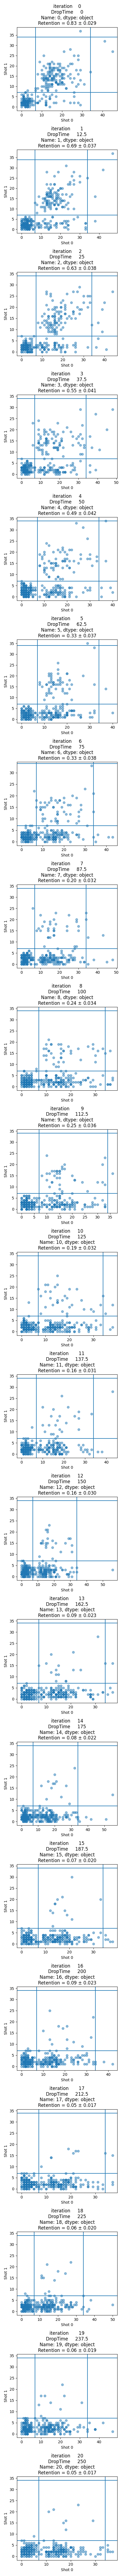

<IPython.core.display.Javascript object>


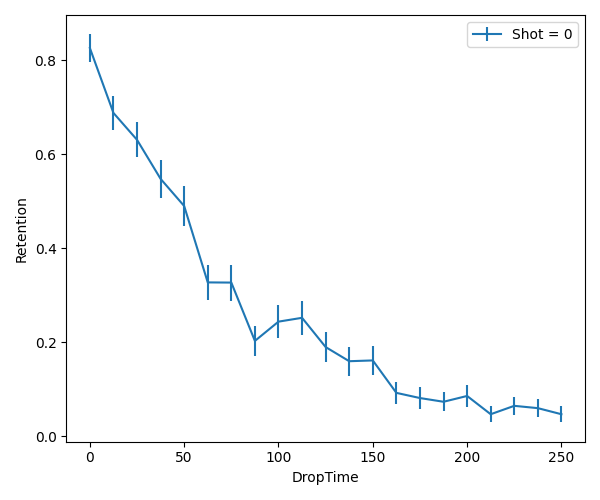

In [4]:
shots = 2

fit_cuts = True
#Use cuts derived from fitting in "Cuts" cell? If False hardcoded cut bellow will be used
if fit_cuts:
    try:
        print(f"printing cuts array {cuts}")
    except NameError:
        fit_cuts = False

# Set count data variable, so this works regadless of device
cut = 7  # 0 atom - 1 atom cut
multi_cut = 34  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1).mean(1)
    
    single_loading = (count_data < exp_multi_cuts)*(count_data > exp_cuts) # Measurements that were loaded
else:
    single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
    exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration
#print(retained)
#print(loaded)
loaded = [10**-6 if l==0 else l for l in loaded]
#print(loaded)

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

print(retention)

plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
    
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(4.5,4.5*len(iterations)))
    for iteration, row in iterations.iterrows():
        if fit_cuts:
            cut = cuts[iteration]
            multi_cut = multi_cuts[iteration]
        iteration = int(row["iteration"])
        ax=axarr[iteration]
        ax.scatter(count_data[iteration,:,0],count_data[iteration,:,1],alpha=0.5)
        ax.axvline(cut)
        ax.axhline(cut)
        
        ax.axvline(multi_cut)
        ax.axhline(multi_cut)
        ax.set_title(str(row)+f"\nRetention = {retention[iteration]:.2f} $\pm$ {retention_error_bar[iteration]:.3f}")
        ax.set_xlabel("Shot 0")
        ax.set_ylabel("Shot 1")
    fig.tight_layout()
    fig.show()

fig,ax = default_plotting(iterations,retention,retention_error_bar,description = "Retention")
#exp_ts = datetime.fromtimestamp(exp_time).strftime('%Y_%m_%d_%H_%M_%S_')
#fig.savefig(f"C:\\Users\\Hybrid\\Pictures\\For wiki\\Ryd Spectroscopy\\{exp_ts}retention.png")

In [ ]:
ts = abs(iterations.independent_variables[iterations.ivars[0]])
fig,ax = plt.subplots(1,1)
ax.errorbar(ts,retention,yerr=retention_error_bar)
ax.set_xlabel(iterations.ivars[0]+"(ms)")
ax.set_ylabel("Retention")
ax.set_xscale("log")
fig.show()


## New Dependent Variables Template

In [ ]:
def depump_time(iterations):
    iname = "OP_shelve_time"
    if iname in iterations.ivars:
        return(abs(iterations.independent_variables[iname]))
    else:
        raise RuntimeError(f"No independent variable named {iname}")
iterations.new_dependent_variable("depump_time", depump_time)
iterations

## Temperature

<IPython.core.display.Javascript object>


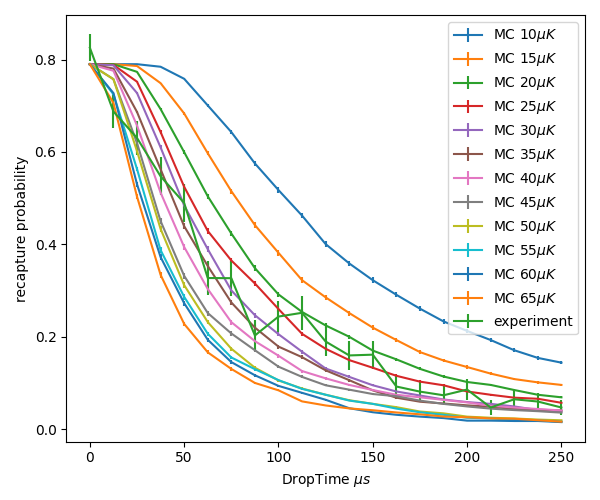

Text(0.5, 25.722222222222214, 'DropTime $\\mu s$')

In [7]:
# FORT parameters as of 2023.05.31
P = 10.1e-3 # W
w0 = 2.6e-6 # m 
wl = 938e-9 # m

tlist = iterations.independent_variables[iterations.ivars[0]]*1e-6
temps = arange(10,70,5)*1e-6
rets = zeros((len(tlist),len(temps)+1))
ret_stds = zeros(rets.shape)
for i,temp in enumerate(temps):
    rets[:,i],ret_stds[:,i] = drop_recapture_MC(tlist, temp, P, w0,v0=[0.0,0.0,0.0])

rbl = 0.79
rets *= rbl
ret_stds *= rbl
rets[:,-1] = retention
ret_stds[:,-1] = retention_error_bar
shots = [f"MC ${temp*1e6:.0f}\mu K$" for temp in temps]+["experiment"]
fig,ax = default_plotting(iterations,rets,ret_stds,shots,description="recapture probability")

ax.set_xlabel(f"{iterations.ivars[0]} $\mu s$")

28.656371161446636 +- 1.3266631022325308 uK


<IPython.core.display.Javascript object>


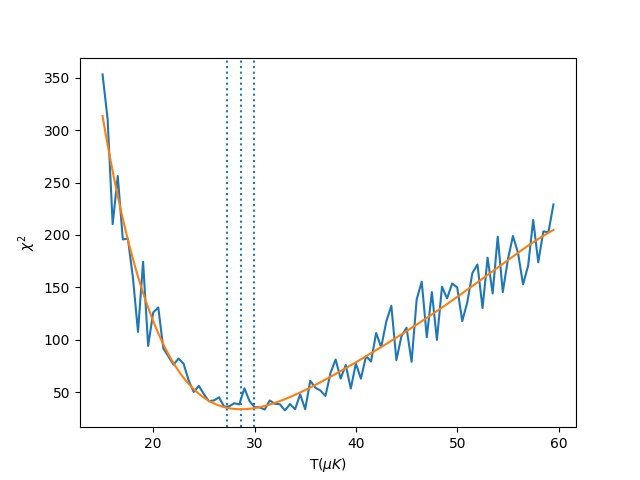

<IPython.core.display.Javascript object>


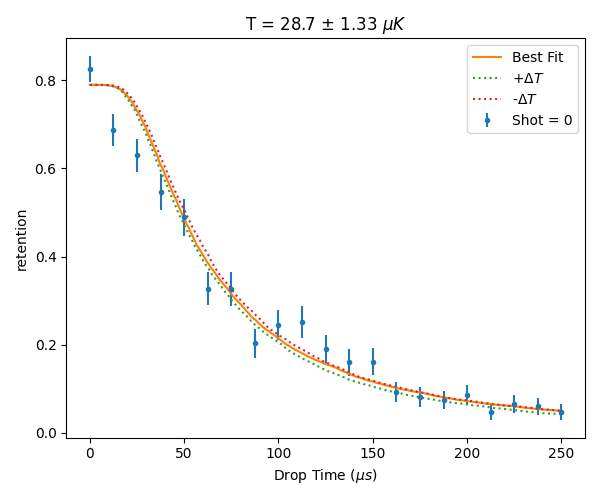

In [10]:
def fit_function(x, a, b, c, d, e, x0):
    return(a*(x-x0)**5 + b*(x-x0)**4 + c*(x-x0)**3 + d*(x-x0)**2 + e)

temp_list = arange(15,60,0.5)


max_retention = 0.79
fit_temp, sigma_fit_temp, chi_square, popt = get_temp(iterations, retention, retention_error_bar, max_retention=max_retention, p=P, w0=w0, temp_list=temp_list)
print(f"{fit_temp} +- {sigma_fit_temp} uK")
fig,ax= plt.subplots(1,1)
ax.plot(temp_list, chi_square)
ax.axvline(fit_temp,ls=":")
if sigma_fit_temp < fit_temp:
    ax.axvline(fit_temp+sigma_fit_temp,ls=":")
    ax.axvline(fit_temp-sigma_fit_temp,ls=":")
ax.set_xlabel("T($\mu K$)")
ax.set_ylabel("$\chi^2$")
tlist = linspace(min(temp_list),max(temp_list),1000)
ax.plot(tlist,fit_function(tlist,*popt))
fig.show()

fig,ax=default_plotting(iterations,retention,retention_error_bar,description="retention",fmt=".")
ts = iterations.independent_variables[iterations.ivars[0]]
tlist = linspace(min(ts),max(ts),1000)
ax.plot(tlist,drop_recapture_MC(tlist*1e-6, fit_temp*1e-6, P, w0,n=10000)[0]*max_retention,label="Best Fit")
if sigma_fit_temp < fit_temp:
    ax.plot(tlist,drop_recapture_MC(tlist*1e-6, (fit_temp+sigma_fit_temp)*1e-6, P, w0,n=10000)[0]*max_retention,label="+$\Delta T$",ls=":")
    ax.plot(tlist,drop_recapture_MC(tlist*1e-6, (fit_temp-sigma_fit_temp)*1e-6, P, w0,n=10000)[0]*max_retention,label="-$\Delta T$",ls=":")
ax.legend()
ax.set_xlabel("Drop Time ($\mu s$)")
ax.set_title(f"T = {fit_temp:.1f} $\pm$ {sigma_fit_temp:.2f} $\mu K$")
fig.tight_layout()
fig.show()

In [ ]:
# FORT parameters as of 2023.05.05
P = 10.1e-3 # W
w0 = 2.66e-6 # m 
wl = 938e-9 # m


def fit_function(x, a, b, c, d, e, x0):
    return(a*(x-x0)**5 + b*(x-x0)**4 + c*(x-x0)**3 + d*(x-x0)**2 + e)

temp_list = arange(10,50,0.5)
tlist = linspace(min(temp_list),max(temp_list),1000)

drop_time_name, drop_time_ind = get_var(iterations, "DropTime")
it_var_name, it_var_ind = get_var(iterations, "Recool_D2_detuning")

drop_times = iterations.independent_variables[drop_time_name]
it_var_values = iterations.independent_variables[it_var_name]

ret_per_it_var = zeros((len(drop_times), len(it_var_values)))
ret_err_per_it_var = zeros((len(drop_times), len(it_var_values)))
fig, ax = plt.subplots(1,1, figsize=(8,5))

for it_value_indx, it_value in enumerate(it_var_values):
    iterations_for_it_var_value = iterations[it_var_name]==it_value
    ret_for_it_var = retention[iterations_for_it_var_value]
    ret_err_for_it_var = retention_error_bar[iterations_for_it_var_value]
    ax.errorbar(x=drop_times, y=ret_for_it_var, yerr=ret_err_for_it_var, label=f"{it_value}")
    ret_per_it_var[:, it_value_indx] = ret_for_it_var
    ret_err_per_it_var[:, it_value_indx] = ret_err_for_it_var

ax.legend()
ax.set_title("Experimental Drop Recapture Comparison")
ax.set_ylabel("Retention")
ax.set_xlabel("Drop Time ($\mu s$)")
fig.tight_layout()
fig.show()

for it_value_indx, it_value in enumerate(it_var_values):
    fig, ax = plt.subplots(2, 1, figsize=(8,10))
    retention_itvar = ret_per_it_var[:, it_value_indx]
    retention_error_bar_itvar = ret_err_per_it_var[:, it_value_indx]
    control_retention = retention[0]
    fit_temp, sigma_fit_temp, chi_square, popt = get_temp(iterations, retention_itvar, retention_error_bar_itvar, max_retention=control_retention, p=P, w0=w0, temp_list=temp_list)
    ax[0].plot(temp_list, chi_square)
    ax[0].axvline(fit_temp,ls=":")
    if sigma_fit_temp < fit_temp:
        ax[0].axvline(fit_temp+sigma_fit_temp,ls=":")
        ax[0].axvline(fit_temp-sigma_fit_temp,ls=":")
    ax[0].set_xlabel("T($\mu K$)")
    ax[0].set_ylabel("$\chi^2$")
    ax[0].plot(tlist,fit_function(tlist,*popt))
    
    
    
    ts = iterations.independent_variables[iterations.ivars[0]]
    ts_fine = linspace(min(ts),max(ts),1000)
    ax[1].plot(ts_fine,drop_recapture_MC(ts_fine*1e-6, fit_temp*1e-6, P, w0,n=10000)[0]*control_retention,label="Best Fit")
    if sigma_fit_temp < fit_temp:
        ax[1].plot(ts_fine,drop_recapture_MC(ts_fine*1e-6, (fit_temp+sigma_fit_temp)*1e-6, P, w0,n=10000)[0]*control_retention,label="+$\Delta T$",ls=":")
        ax[1].plot(ts_fine,drop_recapture_MC(ts_fine*1e-6, (fit_temp-sigma_fit_temp)*1e-6, P, w0,n=10000)[0]*control_retention,label="-$\Delta T$",ls=":")
    ax[1].legend()
    ax[1].set_xlabel("Drop Time ($\mu s$)")
    ax[1].set_title(f"T = {fit_temp:.1f} $\pm$ {sigma_fit_temp:.2f} $\mu K$")
    
    ax[1].errorbar(x=ts, y=retention_itvar, yerr=retention_error_bar_itvar, label="Experimental Data", color="black")
    
    fig.suptitle(f"Iteration: {it_value_indx}, iter_val = {it_value}")
    fig.tight_layout()
    fig.show()
    print(control_retention)


## Fit 1D scan

<IPython.core.display.Javascript object>


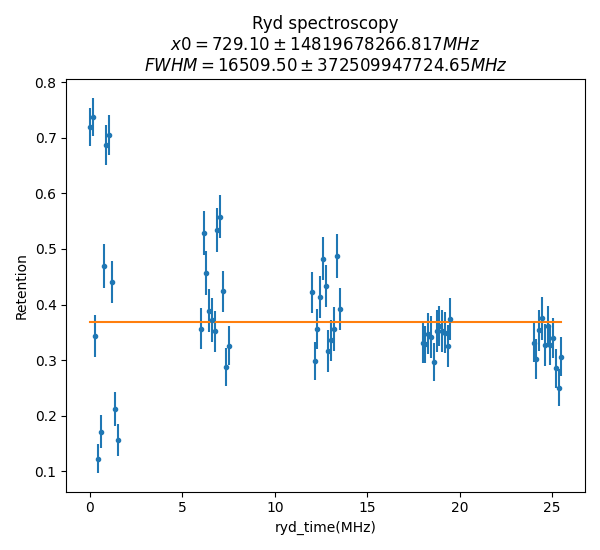

In [5]:
rabi = False
decoh = False

'''# Poissonian S-curve
func = lambda t, r, Nc,a: a*(1-gammainc(Nc,r*t))
guess=[
    81/1.3,
    81,  # expected number of photons needed to boil out of the trap
    0.8
]
title="BA S-curve\n$r = {0[0]:.1f} \pm {1[0]:.2f} KHz$\n$Nc = {0[1]:.1f}\pm{1[1]:.2f}$"
unit="time"
'''

#Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a, o  : lorenz(x, x0, fwhm, a, o)
guess = [
    38.5,
    0.5,
    -.8,
    0.8
]
#title = "uW Spectroscopy\nx0 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nFWHM = {0[1]:.2e} $\pm$ {1[1]:.2e}(MHz)"
#title = "OP spectroscopy\n$x0 = {0[0]:.1f} \pm {1[0]:.2f}MHz$\n$FWHM = {0[1]:.2f} \pm {1[1]:.2F} MHz$"
#title = "685 spectroscopy\n$x0 = {0[0]:.1f} \pm {1[0]:.2f}MHz$\n$FWHM = {0[1]:.2f} \pm {1[1]:.2F} MHz$"
title = "Ryd spectroscopy\n$x0 = {0[0]:.2f} \pm {1[0]:.3f}MHz$\n$FWHM = {0[1]:.2f} \pm {1[1]:.2F} MHz$"
unit = "MHz"

'''
# 5pi Lorenzian
func =  lambda x, x0, fwhm, rabi, a, o  : lorenz(x, x0, fwhm*1e-3, a, 0)*cos(2*pi*sqrt((rabi*1e-3)**2+(x-x0)**2)*129/2+pi/2)**2+o
guess = [
    0.022,
    17,
    19.53125,
    0.0001,
    0.01
]
title = "Clock spectroscopy\n$x0 = {0[0]:.4f} \pm {1[0]:.5f}MHz$\n$FWHM = {0[1]:.2f} \pm {1[1]:.2F} kHz$\n$\Omega = 2\pi\\times {0[2]:.1f}\pm{1[2]:.2f} kHz$"
unit = "kHz"

'''
'''
# Two Lorentzians
#d1 = 8.5
#d2 = 10  
func =  lambda x, x1, x2, fwhm1, fwhm2, a1, a2,o: lorenz(x, x1, fwhm1, -abs(a1), 0) + lorenz(x, x2, fwhm2, -abs(a2), 0) + o
guess =  [
    150.25,
    152.3, 
    0.1, 
    0.5, 
    0.2, 
    0.5,
    0.7
]

arg_names = [
    "$\mu_1$ (MHz)",
    "$\mu_2$ (MHz)",
    "$\Gamma_1$ (MHz)",
    "$\Gamma_2$ (MHz)",
    "Amplitude 1",
    "Amplitude 2",
    "Offset"]
title = "Quadupole Spectroscopy\n" + "\n".join([f"$\mu_{i}={{0[{i-1}]:.1f}}\pm {{1[{i-1}]:.2f}}$ MHz\n$\Gamma_{i}={{0[{i-1+2}]:.1f}}\pm {{1[{i-1+2}]:.2f}}$ MHz" for i in range(1,3)])
unit = "MHz" '''
'''
# Four Lorenzians
#Quad Lorenzian
d1 = 8.5   
d2 = 10  
func =  lambda x, x0, x1, x2, x3, fwhm, a: lorenz(x, x0, 2*fwhm, -abs(a), 0) + lorenz(x, x1, 2*fwhm, -abs(a), 0) + lorenz(x, x2,2*fwhm, -abs(a), 0) + lorenz(x, x3, 2*fwhm, -abs(a), 0) + 0.75
guess =  [
    108.5, 
    114.5, 
    120.6, 
    126.6, 
    0.1, 
    -0.10
]

arg_names = [
    "$\mu_1 (MHz)$",
    "$\mu_2 (MHz)$",
    "$\mu_3 (MHz)$",
    "$\mu_4 (MHz)$",
    "FWHM (MHz)",
    "Amplitude 1",
    "Amplitude 2",
    "Amplitude 3",
    "Amplitude 4",
    "Offset"]
title = "Rydberg Spectroscopy in 2V Bias\n" + "\n".join([f"$\mu_{i}={{0[{i}]:.1f}}\pm {{1[{i}]:.2f}}MHz$" for i in range(4)]) + "\n$FWHM = {0[4]:.2f} \pm {1[4]:.3f}MHz$"
unit = "MHz" 
'''
'''
# Rapidly Decaying Rabi Oscillations
a = 0.6
o = 0.2
func = lambda t, freq, tau: 0.5*(a*cos(4*pi*freq*t/2)*exp(-(t/(tau))**1)+a)+o
guess = [
    0.8,
    6.8
]
title = "Rydberg Rabi\n$\Omega$ = 2$\pi$x{0[0]:.2f} $\pm$ {1[0]:.3f}MHz\n$T = {0[1]:.1f} \pm {1[1]:.2f}~\\rm \mu s$"
unit = "us"
#rabi = True
#title = "4,0-3,1 Rabi Oscillations\n$\Omega = 2\pi \\times {0[0]:.2f} \pm {1[0]:.3f} ~\\rm kHz$\n"
#title += "$T = {0[1]:.1f} \pm {1[1]:.2f}~\\rm \mu s$"
#title = "FORT clock shift\n$\Delta\omega_c$ = 2$\pi$x{0[0]:.2f} $\pm$ {1[0]:.3f}kHz\nT = {0[1]:.1f} $\pm$ {1[1]:.2f}us"
#title = "Motional FORT Oscillation\n$\omega_T = 2\pi x {0[0]:.1f}KHz \pm 2\pi x {1[0]:.2f}KHz$"
#unit = "$\\rm ms$"
#unit = " ms"
rabi = True
decoh = True
'''
'''
# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, 2*pi*freq, amp, off, pi/2)
guess = [
    0.8,
    0.8,
    0.01
]
title = "Rabi Oscillation\n$\Omega = 2\pi x {0[0]:.1f}MHz \pm 2\pi x {1[0]:.2f}MHz$"
unit = "$\\rm \mu s$"
rabi = True
'''
'''
# Trap Motional Oscillations
func = lambda x, freq, amp, off, phi :rabi_cos(x, 2*pi*freq, amp, off, phi)
guess = [
    15,
    0.8,
    0.0,
    pi/2
]
title = "Motional FORT Oscillation\n$\omega_T = 2\pi x {0[0]:.1f}KHz \pm 2\pi x {1[0]:.2f}KHz$"
unit = "$\mu s$"
rabi = True
'''
'''
# Damped Motional Oscillations
func = lambda t, freq, amp, off, phi, T : 1/2*(amp*cos(2*pi*freq*t*1e-3+phi)**2)*exp(-t/T)+off
guess = [
    25,
    0.8,
    0.3,
    pi/2,
    20
]
title = "Motional FORT Oscillations\n$\omega_t$ = 2$\pi\\times${0[0]:.2f} $\pm$ {1[0]:.2f}KHz\nT = {0[3]:.1f} $\pm$ {1[3]:.2f}$us$"
unit = "$\mu s$"
rabi = True
'''
'''
# 1-exp(-t/T)
func = lambda t,T,a,o: o_m_exp_decay(t,a,T)+o
guess = [
    2,
    0.8,
    0.05
]
title = "T2* = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
#title = "T = {0[0]:.1f}us $\pm$ {1[0]:.2f}us"
#title = "T = {0[0]:.1f}s $\pm$ {1[0]:.2f}s"

unit = "ms"
'''
'''
# a*exp(-t/T)
func = lambda x, a, T: a*(exp_decay(x,1,T))+.15
guess = [
    0.6,
    50
]
title = "OP depump time = {0[1]:.2f}ms $\pm$ {1[1]:.2f}ms"
title = "685 depump time = ${0[1]:.0f} \pm {1[1]:.1f} ~\\rm \mu s$"
unit= "$\\rm \mu s$"
'''
'''
#gaussian beam shape
func = lambda x,mu,w0,a,o: a*exp(-(2*(x-mu)**2)/(w0)**2)+o
guess = [
    120,
    5,
    -0.3,
    0.8
]
title = "595nm beam alignment\n $\mu = {0[0]:.3f} \pm {1[0]:.3f} ~\\rm pixels$\n$w_0 = {0[1]:.1f} \pm {1[1]:.2f} ~\\rm pixels$"
unit = "pix"
'''
'''# Ramsey Fringe
func = lambda x, f, phi, a: a*(1+cos(2*pi*f*1e3*x+phi))/2
guess = [
    0.7,
    0,
    0.5
]
title = "Ramsey, 684nm clock shift\n $\delta \omega_{{clock}} = 2\pi \\times{0[0]:.2f} \pm {1[0]:.3f}MHz$"
unit = "ms"
'''
'''
# Decaying Ramsey Fringe
func = lambda t, f, T,phi, a: a*(1+exp(-t/(T*1e-3))*cos(2*pi*f*1e3*t+phi))/2+0.02
guess = [
    0.4,
    20,
    0,
    0.5
]
title = "Ramsey, 684nm clock shift\n $\delta \omega_{{clock}} = 2\pi \\times{0[0]:.3f} \pm {1[0]:.4f}MHz$\n$T = {0[1]:.1f}\pm{1[1]:.2f}\mu s$"
unit = "ms"
decoh = True
'''
xdat = array(iterations.independent_variables[iterations.ivars[0]])[array(iterations["iteration"],dtype=int)]
#xdat = array(list(iterations.dependent_variables[iterations.dvars[0]].values()))
ydat = array(retention)[array(iterations["iteration"],dtype=int)]
ystd = array(retention_error_bar)[array(iterations["iteration"],dtype=int)]


try:
    if any(ystd == 0):
        popt, pcov = curve_fit(func, xdat, ydat, p0 = guess)
    else:
        popt, pcov = curve_fit(func, xdat, ydat, sigma=ystd, p0 = guess)
    perr = sqrt(diag(pcov))
except RuntimeError as e:
    print(e)
    popt,perr = None, None
    
#unit = "us"
fig, ax = plt.subplots(1,1,figsize=(6,5.5))
ax.errorbar(xdat,ydat,ystd,fmt=".")
xlin = linspace(min(xdat),max(xdat),1000)
if popt is None:
    print("bad fit")
    ax.plot(xlin, func(xlin,*guess))
else:
    ax.plot(xlin, func(xlin,*popt))
    #ax.plot(xdat, func(xdat,*popt))
    if decoh:
        ot = popt[0]*popt[1]
        oterr = ot*sqrt((perr[0]/popt[0])**2+(perr[1]/popt[1])**2)
        title += f"\n$\Omega T = 2\pi\\times{ot:.1f}\pm {oterr:.2f}$"
    if rabi:
        title += f"\n$t_\pi = {1/(2*popt[0]):.4f} \pm {perr[0]/(2*popt[0]**2):.4f}$" + unit
    ax.set_title(title.format(popt,perr))
    # ax.plot(xlin, func(xlin,*guess))
    

ax.set_ylabel("Retention")
ax.set_xlabel(f"{iterations.ivars[0]}({unit})")
#ax.set_xlabel(f"1190nm ULE detuning (MHz)")
fig.tight_layout()
#fig.savefig(f"Rydberg_Spectroscopy_{exp_desc}.png")
fig.show()
#ax.set_xscale("log")

## Fit Rabi oscillations
Here we want to fit just Rydberg Rabi signals. We can use the atom temperature to add the expected drop-recapture dynamics to the fit.

<IPython.core.display.Javascript object>


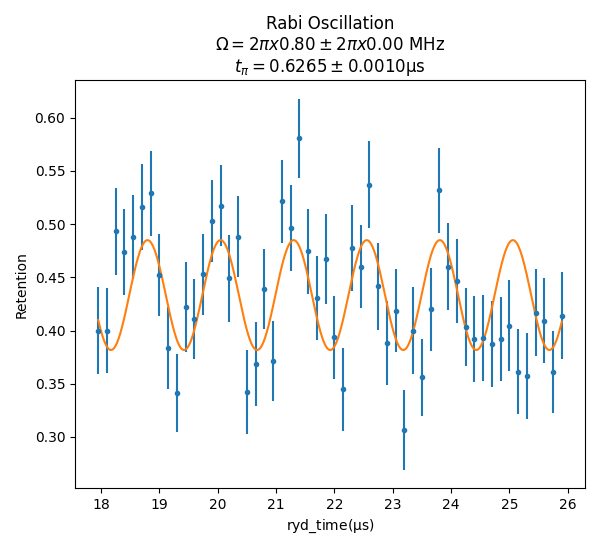

In [8]:
rabi = True
decoh = False
'''
#Decaying Rabi Oscillations

# use order to get better/worse fit
order = 1  # lorentzian decay, dominated by broadening of resonance
#order = 2  # gaussian decay, dominated by uncertainty or rabi frequency
# hard-code visibility parameters to force fit to just extract omega-tau
a=0.6
o=0.2
func = lambda t, freq, tau: 0.5*(a*cos(4*pi*freq*t/2)*exp(-(t/(tau))**order)+a)+o
guess = [
    1.15,
    6.8
]
title = "Rydberg Rabi\n$\Omega$ = 2$\pi$x{0[0]:.2f} $\pm$ {1[0]:.3f}MHz\n$T = {0[1]:.1f} \pm {1[1]:.2f}~\\rm \mu s$"
unit = "us"
decoh = True
'''

# Rabi Oscillations, no decay
func = lambda x, freq, amp, off: rabi_cos(x, 2*pi*freq, amp, off, 0)
guess = [
    0.8,
    0.8,
    0.01,
]
title = "Rabi Oscillation\n$\Omega = 2\pi x {0[0]:.2f} \pm 2\pi x {1[0]:.2f}~\\rm MHz$"
unit = "$\\rm \mu s$"

'''
# Decaying Rabi oscillations, drop-recapture dynamics

# FORT parameters as of 2023.05.31
P = 10.1e-3 # W
w0 = 2.6e-6 # m 
wl = 938e-9 # m
# atom temperature
temperature = 17e-6  # K

drc = lambda t: drop_recapture_MC((t+2.5)*1e-6,temperature,P,w0,v0=[0.0,0.0,0.0],n=10000)[0]

# use order to get better/worse fit
order = 1  # lorentzian decay, dominated by broadening of resonance
#order = 2  # gaussian decay, dominated by uncertainty or rabi frequency
# hard-code visibility parameters to force fit to just extract omega-tau
#a=0.7
#o=0.17
func = lambda t, freq, tau,a,o,d: drc(t)*(0.5*(a*cos(4*pi*freq*t/2)*exp(-(t/(tau))**order)+d)+o)
guess = [
    1.15,
    6.8,
    0.7,
    0.17,
    0.4
]
title = "Rydberg Rabi\n$\Omega$ = 2$\pi$x{0[0]:.2f} $\pm$ {1[0]:.3f}MHz\n$T = {0[1]:.1f} \pm {1[1]:.2f}~\\rm \mu s$"
unit = "us"
decoh = True
'''
'''
# Decaying Rabi oscillations, asymmetric decay

# use order to get better/worse fit
order = 1  # lorentzian decay, dominated by broadening of resonance
#order = 2  # gaussian decay, dominated by uncertainty or rabi frequency
# hard-code visibility parameters to force fit to just extract omega-tau
a=0.7
o=0.13
func = lambda t, freq, tau,T2,f: (0.5*a*(cos(2*pi*freq*t)*exp(-(t/(tau))**order)+1+(f*exp(-t/T2)-f))+o)
guess = [
    0.92,
    10,
    20,
    0.4
]
title = "Rydberg Rabi\n$\Omega$ = 2$\pi$x{0[0]:.2f} $\pm$ {1[0]:.3f}MHz\n$T = {0[1]:.1f} \pm {1[1]:.2f}~\\rm \mu s$"
unit = "us"
decoh = True
'''
xdat = array(iterations.independent_variables[iterations.ivars[0]])[array(iterations["iteration"],dtype=int)]
#xdat = array(list(iterations.dependent_variables[iterations.dvars[0]].values()))
ydat = array(retention)[array(iterations["iteration"],dtype=int)]
ystd = array(retention_error_bar)[array(iterations["iteration"],dtype=int)]


try:
    if any(ystd == 0):
        popt, pcov = curve_fit(func, xdat, ydat, p0 = guess)
    else:
        popt, pcov = curve_fit(func, xdat, ydat, sigma=ystd, p0 = guess)
    perr = sqrt(diag(pcov))
except RuntimeError as e:
    print(e)
    popt,perr = None, None
    
#unit = "us"
fig, ax = plt.subplots(1,1,figsize=(6,5.5))
ax.errorbar(xdat,ydat,ystd,fmt=".")
xlin = linspace(min(xdat),max(xdat),1000)
if popt is None:
    print("bad fit")
    ax.plot(xlin, func(xlin,*guess))
else:
    ax.plot(xlin, func(xlin,*popt))
    #ax.plot(xdat, func(xdat,*popt))
    if decoh:
        ot = popt[0]*popt[1]
        oterr = ot*sqrt((perr[0]/popt[0])**2+(perr[1]/popt[1])**2)
        title += f"\n$\Omega T = 2\pi\\times{ot:.1f}\pm {oterr:.2f}$"
    if rabi:
        title += f"\n$t_\pi = {1/(2*popt[0]):.4f} \pm {perr[0]/(2*popt[0]**2):.4f}$" + unit
    ax.set_title(title.format(popt,perr))
    #ax.plot(xlin, func(xlin,*guess))

#ax.plot(xlin,drc(xlin))

ax.set_ylabel("Retention")
ax.set_xlabel(f"{iterations.ivars[0]}({unit})")
#ax.set_xlabel(f"1190nm ULE detuning (MHz)")
fig.tight_layout()
#fig.savefig(f"Rydberg_Spectroscopy_{exp_desc}.png")
fig.show()
#ax.set_xscale("log")

In [9]:
popt, perr

(array([0.79805786, 0.10325467, 0.38169084]),
 array([0.00133691, 0.01922364, 0.01133294]))

In [15]:
res = retention-func(xdat,*popt)
chi2 = (res**2).sum()
print(f"chi squared = {chi2}")

chi squared = 1.9472002467116742


In [10]:
concatenate((arange(0,1.6,.15), 0.5*8+arange(0,1.6,.15), 0.5*16+arange(0,1.6,.15), 0.5*24+arange(0,1.6,.15)))

array([ 0.91503274, -0.6268013 ,  0.79142714])

In [ ]:
t = 0.572*2
scatter = 1-exp(-t/popt[1])
print(f"probability to scatter out of intermediate state during 2pi Rydberg  pulse: {scatter}")
dephase = 1-exp(-t**2/7.5**2)
print(f"probability to dephase during 2pi Rydberg  pulse: {dephase}")

In [ ]:
f, df = popt[0], perr[0]
alignment_file = r"D:\Data\685_alignment_data_2023-05-11.csv"

entry = {
    "Movement": "V-1Q",
    "f (MHz)": abs(f),
    "df (MHz)": df
}

try:
    df = pd.read_csv(alignment_file,)
    df = df.append(entry, ignore_index=True)
except FileNotFoundError:
    df = pd.DataFrame(entry, index=[0])
df.to_csv(alignment_file,index=False)
df

In [ ]:
last = 20

if len(df) > last:
    dfp = df.loc[-last:]
else:
    dfp = df
    
x = arange(len(dfp))
labels = array(dfp["Movement"])

#plot clock shift
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.errorbar(x,dfp["f (MHz)"],yerr=dfp["df (MHz)"],label="$\mu_0$")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("$\delta \omega_{clock} ~\\rm (MHz)$")
ax.set_xlabel("Movement")
ax.legend()
fig.tight_layout()
fig.show()

In [ ]:
xlin = logspace(-3,1,1000)*3
ylin = exp(-xlin/2)
fig,ax = plt.subplots(1,1)
ax.plot(xlin,ylin)
ax.set_xscale("log")
fig.show()

In [ ]:
ax.tick_params(labelsize=12)
for txt in [ax.xaxis.label,ax.yaxis.label,ax.title]:
    txt.set_fontsize(14)
fig.savefig(f"T2star_{exp_ts}.png")

In [ ]:
(5*pi/128)/(2*pi)

In [ ]:
spec = {"X shim bias (V)": 2, "Date": exp_day}
spec.update({f"mu{i}":popt[i] for i in range(4)})
spec.update({f"dmu{i}":perr[i] for i in range(4)})

spectroscopy_file = "../52P_spectroscopy_and_bias.csv"
try:
    df = pd.read_csv(spectroscopy_file)
    df = df.append(spec, ignore_index=True)
except FileNotFoundError:
    df = pd.DataFrame(spec, index=[0])
df.to_csv(spectroscopy_file,index=False)
df
#specdf = pd.DataFrame(spec)

## Plot 2D scan iteratively

In [ ]:
fig, axarr = iterate_plot_2D(
    iterations,
    retention,
    retention_error_bar,
    iterations.ivars[1],
    iterations.ivars[0],
    "Retention",
    1
)

In [ ]:
from DropRecapture import drop_recapture_MC
# FORT parameters as of 2022.08.15
P = 0.6*18.5e-3 # W
w0 = 2.98e-6 # m 
wl = 938e-9 # m

rt = iterations.fold_to_nd(retention)
rtd = iterations.fold_to_nd(retention_error_bar)
print(rt)
tlist = iterations.independent_variables[iterations.ivars[0]]*1e-6
temps = arange(20,50,5)*1e-6
rets = zeros((len(tlist),len(temps)))
ret_stds = zeros(rets.shape)
for i,temp in enumerate(temps):
    rets[:,i],ret_stds[:,i] = drop_recapture_MC(tlist, temp, P, w0,v0=[0.0,0.0,0.0])

for j, ax in enumerate(axarr):
    shots = [f"MC ${temp*1e6:.0f}\mu K$" for temp in temps]
    for i, temp in enumerate(temps):
        r_bl = 0.8
        #r_bl=0.83
        ax.errorbar(iterations.independent_variables[iterations.ivars[0]],r_bl*rets[:,i],r_bl*ret_stds[:,i],label=shots[i])
        ax.legend()
ax.set_xlabel(f"{iterations.ivars[0]} $\mu s$")

fit_temps = arange(1, 31, 1)*1e-6

for i,temp in enumerate(fit_temps):
    fit_rets, fit_ret_stds = drop_recapture_MC(tlist, temp, P, w0,v0=[0.0,0.0,0.0])
    print(fit_rets)


In [ ]:
w5 = 5e-6
zr = pi*w5**2/595e-9

wz = lambda z : w5*sqrt(1+z**2/zr**2)
wz(iterations.independent_variables["MuxJrFocus"]*1e-3-3.25e-3)

In [ ]:
5*sqrt(2)

In [ ]:
rnd = iterations.fold_to_nd(retention)
erbnd = iterations.fold_to_nd(retention_error_bar)
print(rnd)

visibility = rnd[:,1]-rnd[:,0]
ver = sqrt(erbnd[:,1]**2+rnd[:,0]**2)

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(iterations.independent_variables[iterations.ivars[0]],visibility,ver)
fig.show()

In [ ]:
iterations[iterations.ivars[0]]

In [ ]:
fig.savefig(f"DropRecapture2D-{exp_day}.png")

## Fit the plot 2D scan iteratively

In [ ]:
# Gaussian Functions
func = lambda x, x0, std, a,o : gaussian(x,x0,std*1e-3,a) + o
guess = [
    5.45,
    20,
    -0.02,
    0.8
]
arg_names = ["Mean (mm)", "STD (mm)", "Amplitude"]
title = "Gaussian Dip x0 = {0[0]:.3f} $\pm$ {1[0]:.3f} mm\n$\sigma = {0[1]:.1f}  \pm {1[1]:.2f} ~\\rm \mu m$"
'''
# Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a, o: lorenz(x, x0, fwhm, a, o)
guess = [
    0.001,
    0.012,
    1.1e-4,
    0.01
]
arg_names = ["Mean (MHz)", "FWHM (MHz)", "Amplitude", "Offset"]
title = "Microwave Spectroscopy\nx0 = {0[0]:.4f} $\pm$ {1[0]:.4f}(MHz)\nFWHM = {0[1]:.2e} $\pm$ {1[1]:.2e}(MHz)"
'''
'''
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
'''

'''
# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, freq, amp, off, phi = pi/2)
guess = [
    pi*30,
    0.5,
    0.05
]
title = "$\Omega = 2pi x {0[0]:.1f}KHz \pm {1[0]:.1f}KHz$"
arg_names = ["Omega", "Amplitude", "Offset"]
'''
'''
#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]
'''

x_ivar = iterations.ivars[1]
y_ivar = iterations.ivars[0]
shots = 1

popts, perrs = iterate_fit_2D(
    iterations,
    retention,
    func,
    guess,
    data_error = retention_error_bar,
    x_var =x_ivar,
    it_var=y_ivar,
    shots = shots
)

fig, axarr = iterate_plot_2D(
    iterations,
    retention,
    retention_error_bar,
    iterations.ivars[1],
    iterations.ivars[0],
    "Retention",
    shots,
    fmt="."
)

xlin = linspace(min(iterations[x_ivar]),max(iterations[x_ivar]),1000)
for i, ax in enumerate(axarr):
    for shot in range(shots):
        ax.plot(xlin,func(xlin,*popts[i,shot]))
    ax.set_title(f"{y_ivar} = {iterations.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0],perrs[i,0]))

fig.tight_layout()
#fig.savefig(f"MuxJrFocusHoriz_{exp_ts}.png")
fig.show()


# Plot some results of the above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    ax.errorbar(iterations.independent_variables[y_ivar], popts[:,0,i], yerr = perrs[:,0,i])
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.tight_layout()
    fig.show()

In [ ]:
exp_ts

In [ ]:
std_devs = popts[:,0,0]
std_errs = perrs[:,0,0]

xdata = iterations.independent_variables[y_ivar]
func = lambda x, m, b : m*x+b
guess = [0.07/0.8, 0]

popt, pcov = curve_fit(func, xdata, std_devs, sigma=std_errs,p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(iterations.independent_variables[y_ivar], std_devs, yerr=std_errs, fmt=".")
xlin = linspace(min(xdata),max(xdata),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(f"m = {popt[0]:.3f} $\pm$ {perr[0]:.3f}mm/mm, b = {popt[1]:.3f} $\pm$ {perr[1]:.3f}mm")
#ax.set_title(f"V0 = {popt[0]:.3e} $\pm$ {perr[0]:.3e}V\nm = {popt[1]:.3e} $\pm$ {perr[1]:.3e}$MHz/V^2$")
fig.show()

In [ ]:
std_devs = popts[:,0,1]
std_errs = perrs[:,0,1]

xdata = iterations.independent_variables[y_ivar]
func = lambda z, z0, w0, zr: w0*sqrt(1+((z-z0)/zr)**2)
guess = [3.0,0.010,0.1]

popt, pcov = curve_fit(func, xdata, std_devs, sigma=std_errs,p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(iterations.independent_variables[y_ivar], std_devs, yerr=std_errs)
xlin = linspace(min(xdata),max(xdata),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(f"z0 = {popt[0]:.3f} $\pm$ {perr[0]:.3f}, w0 = {popt[1]:.3f} $\pm$ {perr[1]:.3f}\n zr = {popt[2]:.3f} $\pm$ {perr[2]:.3f}")
#ax.set_title(f"V0 = {popt[0]:.3e} $\pm$ {perr[0]:.3e}V\nm = {popt[1]:.3e} $\pm$ {perr[1]:.3e}$MHz/V^2$")
fig.show()

In [ ]:
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"


popt, pcov = curve_fit(func,iterations.independent_variables[y_ivar],popts[:,0,1],sigma=perrs[:,0,1],p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(iterations.independent_variables[y_ivar], popts[:,0,1], yerr = perrs[:,0,1])
xlin = linspace(min(iterations.independent_variables[y_ivar]),max(iterations.independent_variables[y_ivar]),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(title.format(popt,perr))
ax.set_xlabel(y_ivar)
ax.set_ylabel(f"Amplitude")
fig.show()

# GOOD_Data
Pull data from the good logger and match it with measurements taken

In [4]:
from GOODH5 import load_origin_data
log_fields = ["cryostat_pressure", "cryostat_current"]  # fields that are more useful plotted on a log scale
#stream = "Hybrid_Mux"
#stream = "Hybrid_Mag"
stream = "Hybrid_Beam_Balances"
#stream = "Hybrid_Pressure"
#fields = ["Ryd595","Ryd684"]#"FORT"]#,"KE_powermeter"]
#fields = ["PowerMeter"]
#fields = ["Yshim", "Zshim", "Xshim"]
fields = ["X1","Y1","Z1","X2","Y2","Z2"]
#fields = ["cryostat_pressure","cryostat_voltage"]
GOOD_data = load_origin_data(h5file, iterations, measurements, stream, fields)

<IPython.core.display.Javascript object>


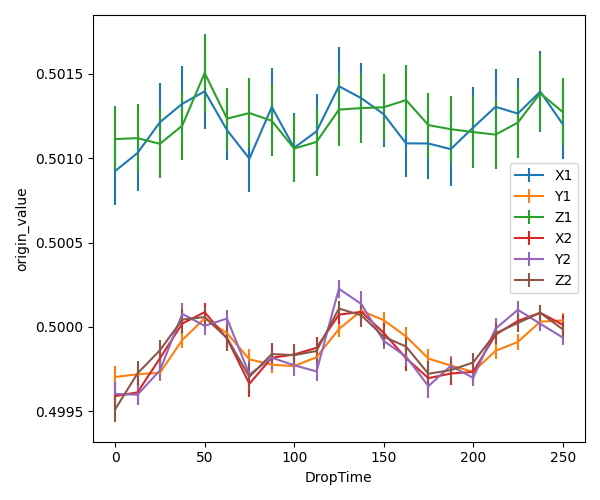

<IPython.core.display.Javascript object>


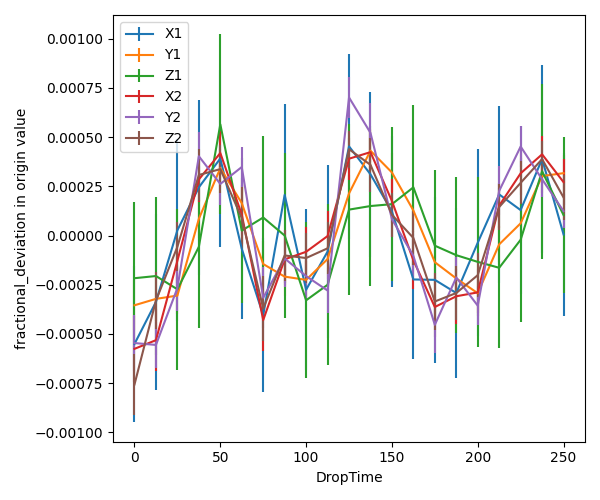

In [7]:
skip =4
def get_mean_std(GOOD_data):
    mean_data = zeros((len(iterations),len(fields)))
    std_data = zeros(mean_data.shape)
    for it, GOOD_df in enumerate(GOOD_data):
        if GOOD_df is not None:
            mean_data[it] = [dataset[:measurements][skip:].mean() for field, dataset in GOOD_df.items() if field != "measurement_time_dt"]
            std_data[it] = [dataset[:measurements][skip:].std()/sqrt(measurements) for field, dataset in GOOD_df.items() if field != "measurement_time_dt"]
        else:
            mean_data[it] = [NaN]*len(fields)
            std_data[it] = [NaN]*len(fields)
    return mean_data, std_data

mean_data, std_data = get_mean_std(GOOD_data)
default_plotting(iterations, mean_data, std_data, fields, "origin_value")
mean_mean = nanmean(mean_data,0)
fig,ax = default_plotting(iterations, (mean_data-mean_mean)/mean_mean, std_data/mean_mean, fields, "fractional_deviation in origin value")
#ax.set_xscale("log")

In [ ]:
ryd_dev = (mean_data-mean_mean)/mean_mean
Odev = sqrt((1+ryd_dev[:,0])*(1+ryd_dev[:,1]))
xdat = iterations.independent_variables[iterations.ivars[0]]
Oterpolate = interp1d(xdat,Odev)
xlin = linspace(min(xdat),max(xdat),1000)
fig,ax=default_plotting(iterations,Odev)
ax.plot(xlin,Oterpolate(xlin))

<IPython.core.display.Javascript object>


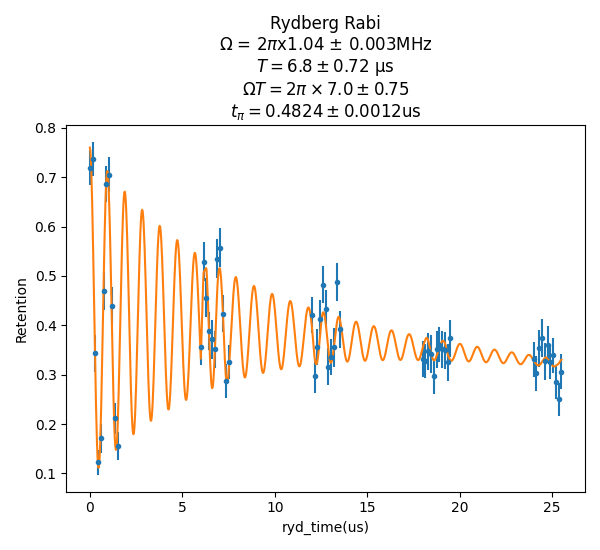

In [15]:
rabi = True
decoh = False

# Decaying Rabi oscillations, asymmetric decay, time-dependent Rabi Frequency

# use order to get better/worse fit
order = 1  # lorentzian decay, dominated by broadening of resonance
#order = 2  # gaussian decay, dominated by uncertainty or rabi frequency
# hard-code visibility parameters to force fit to just extract omega-tau
a=0.67
o=0.09
func = lambda t, freq, tau,T2,f: (0.5*a*(cos(2*pi*freq*Oterpolate(t)*t)*exp(-(t/(tau))**order)+1+(f*exp(-t/T2)-f))+o)
guess = [
    0.92,
    10,
    20,
    0.4
]
title = "Rydberg Rabi\n$\Omega$ = 2$\pi$x{0[0]:.2f} $\pm$ {1[0]:.3f}MHz\n$T = {0[1]:.1f} \pm {1[1]:.2f}~\\rm \mu s$"
unit = "us"
decoh = True

xdat = array(iterations.independent_variables[iterations.ivars[0]])[array(iterations["iteration"],dtype=int)]
#xdat = array(list(iterations.dependent_variables[iterations.dvars[0]].values()))
ydat = array(retention)[array(iterations["iteration"],dtype=int)]
ystd = array(retention_error_bar)[array(iterations["iteration"],dtype=int)]


try:
    if any(ystd == 0):
        popt, pcov = curve_fit(func, xdat, ydat, p0 = guess)
    else:
        popt, pcov = curve_fit(func, xdat, ydat, sigma=ystd, p0 = guess)
    perr = sqrt(diag(pcov))
except RuntimeError as e:
    print(e)
    popt,perr = None, None
    
#unit = "us"
fig, ax = plt.subplots(1,1,figsize=(6,5.5))
ax.errorbar(xdat,ydat,ystd,fmt=".")
xlin = linspace(min(xdat),max(xdat),1000)
if popt is None:
    print("bad fit")
    ax.plot(xlin, func(xlin,*guess))
else:
    ax.plot(xlin, func(xlin,*popt))
    #ax.plot(xdat, func(xdat,*popt))
    if decoh:
        ot = popt[0]*popt[1]
        oterr = ot*sqrt((perr[0]/popt[0])**2+(perr[1]/popt[1])**2)
        title += f"\n$\Omega T = 2\pi\\times{ot:.1f}\pm {oterr:.2f}$"
    if rabi:
        title += f"\n$t_\pi = {1/(2*popt[0]):.4f} \pm {perr[0]/(2*popt[0]**2):.4f}$" + unit
    ax.set_title(title.format(popt,perr))
    #ax.plot(xlin, func(xlin,*guess))

#ax.plot(xlin,drc(xlin))

ax.set_ylabel("Retention")
ax.set_xlabel(f"{iterations.ivars[0]}({unit})")
#ax.set_xlabel(f"1190nm ULE detuning (MHz)")
fig.tight_layout()
#fig.savefig(f"Rydberg_Spectroscopy_{exp_desc}.png")
fig.show()
#ax.set_xscale("log")

In [ ]:
pm = mean_data[:,1]
pm_std = std_data[:,1]

pin = mean_data[:,0]
pin_std = std_data[:,0]

T = pm/pin
T_std = T * sqrt((pm_std/pm)**2+(pin_std/pin)**2)

fig,ax=default_plotting(iterations,T,T_std,1,"KE Transmission")

In [ ]:
its = iterations
#its = iter_trunc
#its=it_opt

'''#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]'''

func = lambda x, x0, w, a, o: a*erfc(sqrt(2)*(x-x0) / w ) + o
guess = [
    5.963,
    5.0e-3,
    0.9,
    0.3
]
title= "Knife Edge Width Measurement\nx0 = {0[0]:.4f}mm $\pm$ {1[0]:.4f}mm\nw = {0[1]:.5f}mm $\pm$ {1[1]:.5f}mm"
arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Amplitude (mW)", "Offset (mW)"]
#arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Offset (mW)"]

x_ivar = its.ivars[0]
y_ivar = its.ivars[1]
shots = 1

#field = "PowerMeter"
#field_ind = where(array(fields,dtype=str) == field)[0][0]
#field_div = "FORT"
#field_div = "Ryd684"
#field_div_ind = where(array(fields,dtype=str) == field_div)[0][0]
#ydat = mean_data[:,field_ind]/mean_data[:,field_div_ind]
#yerr= ((std_data[:, field_ind] / mean_data[:, field_ind]) + (std_data[:, field_div_ind] / mean_data[:, field_div_ind])) * ydat
ydat = T
yerr = T_std
ydat = nan_to_num(ydat)
yerr = nan_to_num(yerr,nan=min(yerr))


popts, perrs = iterate_fit_2D(
    its,
    ydat,
    func,
    guess,
    data_error = yerr,
    x_var = x_ivar,
    it_var = y_ivar,
    shots = shots
)

plot_iter = True # True
if plot_iter:
    fig, axarr = iterate_plot_2D(
        its,
        ydat,
        yerr,
        x_ivar,
        y_ivar,
        "Mean Power past knife-edge(mW)",
        shots,
        fmt=".",
        axsize=(4,4)
    )

    xlin = linspace(min(its[x_ivar]),max(its[x_ivar]),1000)
    for i, ax in enumerate(axarr):
        for shot in range(shots):
            ax.plot(xlin,func(xlin,*popts[i,shot]))
        ax.set_title(f"{y_ivar} = {its.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0],perrs[i,0]))
    fig.tight_layout()
    fig.show()

# Plot the fit parameters above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    ax.errorbar(its.independent_variables[y_ivar], popts[:,0,i], yerr = perrs[:,0,i],fmt=".")
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.tight_layout()
    fig.show()
    


In [ ]:
widths = popts[:,0,1]*1e3  # um
dwidths = perrs[:,0,1]*1e3 # um

x = array(iterations.independent_variables["zzz"])
fig,ax = plt.subplots(1,1,figsize=(4.5,5))
ax.errorbar(x,widths,dwidths,fmt=".")

ax.set_xlabel("MuxJrFocus (mm)")
ax.set_ylabel("595nm waist ($\\rm \mu m$)")

func = lambda z,z0,zr,w0 : w0*sqrt(1+((z-z0)/zr)**2)
guess = [0, pi*(3e-3)**2/595e-6, 3]

popt, pcov = curve_fit(func,x,widths,sigma=dwidths,p0=guess)
perr = sqrt(diag(pcov))

xlin = linspace(min(x),max(x),1000)
ax.plot(xlin,func(xlin,*popt))

ax.set_title(f"$z_0 = {popt[0]:.3f} \pm {perr[0]:.4f}$ mm\n $z_r = {popt[1]:.3f} \pm {perr[1]:.4f}$ mm\n$w_0 = {popt[2]:.2f} \pm {perr[2]:.3f} \\rm \mu m$")
fig.tight_layout()
fig.show()

In [ ]:
w0 = 3  # um
dw0 = 0.2  # um
l = 595e-3  # um

zr = pi*w0**2/l
print(zr)
print(pi*(w0+dw0)**2/l)

In [ ]:
from GOODH5 import datetime_encoding, time_str
import csv 
import datetime

csv_file_name = 'loading_vs_time.csv'
time_str = "start_time_str"
unix_epoch = datetime.datetime(1970, 1, 1)
fixed_cut = 8
fixed_multi_cut = 30
print("DID THIS")
def get_start_time(iterations: Iterations, iteration_no: int, measurement_no: int=None):
    """Returns start time of measurement (as datetime object) in a given iteration within the iterations object. 
    If no measurement number is given, the result returned is the start of the given iteration."""
    
    h5file_rel = iterations.results
    if measurement_no is None:
        it_start = h5file_rel[f"iterations/{iteration_no}"].attrs[time_str]
    else:
        it_start = h5file_rel[f"iterations/{iteration_no}/measurements/{measurement_no}"].attrs[time_str]
        
    return(it_start)


last_seven_day = [x for x in os.walk(r"./../..")][0][1][-7:]

experiments_run_today = [x for x in os.walk(r"./..")][0][1]

with open(csv_file_name, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Shot0", "Shot1"])
    print(f"Grabbed loading data from the following experiments (zero_cut = {fixed_cut} and multi_cut = {fixed_multi_cut}): \n")
    for experiment_name in experiments_run_today:

        directory = os.path.join(os.path.dirname(os.getcwd()), experiment_name)
        if(os.path.exists(os.path.join(directory, 'notes.txt'))):

            with h5py.File(os.path.join(directory, 'results.hdf5')) as h5file_exp:

                iterations_rel = Iterations(h5file_exp)
                num_its = len(h5file_exp['iterations'])
                num_measure = h5file_exp['settings/experiment/measurementsPerIteration'][()]+1
                drop_bins = h5file_exp["/iterations/0/variables/RO1_drops"][()]
                ro_bins = h5file_exp["/iterations/0/variables/RO1_bins"][()]
                shots_per_measurement = int(h5file_exp['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])  # Standard
                shots_per_measurement = 2  # Single RO
                counter_bin, counter_shot = counterh5.load_data(h5file_exp, drop_bins, ro_bins, shots=shots_per_measurement)
                count_d = counter_shot

                zero_loading = (count_d < fixed_cut).sum(1)/num_measure
                zero_loading_error_bar = shot_error(zero_loading, num_measure)
                multi_loading = (count_d > fixed_multi_cut).sum(1)/num_measure
                multi_loading_error_bar = shot_error(multi_loading, num_measure)
                single_loading = 1-(zero_loading+multi_loading)
                single_loading_error_bar = shot_error(single_loading, num_measure)
                iter_starts_exp = [get_start_time(iterations_rel, N) for N in range(num_its)]
                    
                for j in range(num_its):
                    seconds_from_epoch = (datetime.datetime.strptime(iter_starts_exp[j], "%Y-%m-%d %H:%M:%S") - unix_epoch).total_seconds()
                    writer.writerow([seconds_from_epoch, single_loading[j, 0], single_loading[j, 1]])
                    
        print(directory)
        
    print(f"\nLoading data should now be located in {csv_file_name}")    
        
    
                
    


In [ ]:
import pandas as pd

unix_epoch = datetime.datetime(1970, 1, 1)

temp_log_folder = "C:\\Users\\Hybrid\\LakeshoreTemperatureLogs\\"
temp_log = "TempLog20230124.xls"
dfs = pd.read_excel((temp_log_folder + temp_log), sheet_name="Sheet0", engine="xlrd")
#Start Point sp
sp_raw = (dfs['Unnamed: 1'][0]).split(' ')
sp = datetime.datetime.strptime(f"{sp_raw[1]} {sp_raw[2]} {sp_raw[5]} {sp_raw[3]}", '%b %d %Y %H:%M:%S')
sp_seconds_since_epoch = (sp - unix_epoch).total_seconds()
print(sp, sp_seconds_since_epoch)

TimeColumn = dfs['Model 218 Temperature Monitor - SN:LSB1CN'][3:] #in milliseconds
TimeColumn = (TimeColumn / 1000) + sp_seconds_since_epoch #in seconds
CryoTime = pd.to_datetime(TimeColumn, unit='s')
TOC = dfs['Unnamed: 1'][3:]


In [ ]:
import matplotlib.dates as mdates

loading_df1 = pd.read_csv(csv_file_name)
print(loading_df1)
loading_df2 = pd.read_csv("loading_vs_time2.csv")
print(loading_df2)
loading_df = loading_df2.append(loading_df1, ignore_index=True)


ExpTime = pd.to_datetime(loading_df['Time'], unit='s')

fig, (ax1, ax2) =plt.subplots(2, 1, sharex=True)
ax1.plot(CryoTime, TOC)
ax2.plot(ExpTime, loading_df['Shot0'])
fig.suptitle("Comparison of Cryostat Temperature and Single Loading Data")
ax1.set_ylabel("Kelvin")
ax2.set_ylabel("Loading")
ax1.set_title("Cryostat Temperature")
ax2.set_title("Shot 0")
ax3.set_xlabel("Time")
fig.show()

In [ ]:
Iterations

In [ ]:
temp_df =  pd.read_csv(r"D://Data/Temp Logs/PICOS temp log 20221005.csv")
temp_df

print(h5file["iterations"].items())

iteration_times = zeros(len(iterations), dtype=datetime)
for iteration, i_group in h5file["iterations"].items():
    iteration = int(iteration)
    iteration_times[iteration] = datetime.strptime(i_group.attrs[time_str], datetime_encoding)

# initial time to pull data
start_time = min(iteration_times)

# get start time of last measurement
meas_inds = zeros(measurements, dtype=int)
for m, m_tup in enumerate(h5file[f"iterations/{len(iterations) - 1}/measurements"].items()):
    meas_inds[m] = int(m_tup[0])
last_measurement = h5file[f"iterations/{len(iterations) - 1}/measurements/{max(meas_inds)}"]
end_time_str = last_measurement.attrs[time_str]
# final time to pull data
end_time = datetime.strptime(end_time_str, datetime_encoding)

tdf = temp_df.loc[(temp_df["Unnamed: 0"] > datetime.timestamp(start_time))&(temp_df["Unnamed: 0"] < datetime.timestamp(end_time))]

temps = zeros((len(iterations),len(tdf.columns)-1))
tstd = zeros(temps.shape)
for i, itime in enumerate(iteration_times):
    if i+1 < len(iteration_times):
        stop = iteration_times[i+1]
    else:
        stop = end_time
    
    sub = tdf.loc[(tdf["Unnamed: 0"] < datetime.timestamp(end_time)) & (tdf["Unnamed: 0"] > datetime.timestamp(itime))]
    j = 0
    for column in sub.columns:
        if column=="Unnamed: 0":
            continue
        temps[i,j] = array(sub[column]).mean()
        tstd[i,j] = array(sub[column]).std()/sqrt(len(sub))
        j+=1
cols = [col for col in tdf.columns if col != "Unnamed: 0"]
tdf

In [ ]:
default_plotting(iterations, temps, tstd, shots=cols, description="Temp")
default_plotting(iterations, (temps-mean(temps,0)), tstd, shots=cols, description="Temp change (C)")

In [ ]:
end_time = h5file["settings/experiment/completionTime"][()]
#print(f"end time = {datetime.fromtimestamp(int(end_time))}")
start_time =h5file["settings/experiment/timeStarted"][()]
print(f"start time = {datetime.fromtimestamp(int(start_time))}")
end_time = start_time + h5file["settings/experiment/timeElapsed"][()]
print(f"end time = {datetime.fromtimestamp(int(end_time))}")

it0_time = h5file["iterations/0"].attrs["start_time"]
print(datetime.fromtimestamp(int(it0_time)))
it0_ts = h5file["iterations/0"].attrs["start_time_str"]
print(it0_ts)

In [ ]:
iteration_times = zeros(len(iterations), dtype=datetime)
for iteration, i_group in results_file["iterations"].items():
    iteration = int(iteration)
    iteration_times[iteration] = datetime.strptime(i_group.attrs[time_str], datetime_encoding)

# initial time to pull data
start_time = min(iteration_times)

# get start time of last measurement
meas_inds = zeros(measurements, dtype=int)
for m, m_tup in enumerate(results_file[f"iterations/{len(iterations) - 1}/measurements"].items()):
    meas_inds[m] = int(m_tup[0])
last_measurement = results_file[f"iterations/{len(iterations) - 1}/measurements/{max(meas_inds)}"]
end_time_str = last_measurement.attrs[time_str]
# final time to pull data
end_time = datetime.strptime(end_time_str, datetime_encoding)



In [ ]:
t_n = temp_df["Unnamed: 0"]
t = [datetime.fromtimestamp(ti) for ti in t_n]
t[-1]

In [ ]:
fluct_data = array((mean_data - mean_mean)/mean_mean)
fluct_std = array(std_data/mean_mean)

fluct_data /= abs(fluct_data).max()
fluct_std /= abs(fluct_data).max()

fig,ax = default_plotting(iterations, fluct_data, fluct_std, fields, "fractional_deviation in origin value")

ret_dev = (retention-retention.mean())/retention.mean()
ret_std = retention_error_bar/retention.mean()

ret_dev /= max(abs(ret_dev))
ret_std /= max(abs(ret_dev))

ax.errorbar(iterations.independent_variables[iterations.ivars[0]],ret_dev,ret_std,label="retention deviation")
ax.legend()

In [ ]:
help(max)

In [ ]:
fluct_data = (mean_data - mean_mean)/mean_mean
fluct_std = std_data/mean_mean

exp_data = retention
exp_std = retention_error_bar

fig,axar=plt.subplots(len(fields),1,figsize=(8,4*(len(fields))))
for i, field in enumerate(fields):
    ax = axar[i]
    ax.errorbar(fluct_data[:,i],exp_data,yerr=exp_std,xerr=fluct_std[:,i],fmt=".",alpha=0.5)
    ax.set_title(field)
fig.tight_layout()
fig.show()

In [ ]:
fluct_data = array((mean_data - mean_mean)/mean_mean)
fluct_std = array(std_data/mean_mean)

fluct_data /= abs(fluct_data).max()

fluct_std -= fluct_std[:,0].mean()
fluct_std /= abs(fluct_std[:,0]).max()

ret_dev = (retention-retention.mean())/retention.mean()
ret_std = retention_error_bar/retention.mean()

ret_dev /= max(abs(ret_dev))
ret_std /= max(abs(ret_dev))

ar = zeros((len(retention),2))
ar[:,0] = fluct_std[:,0]
ar[:,1] = ret_dev
default_plotting(iterations, ar, shots = ["Xshim Fluctuations", "Retention_fluctuations"])

fig,ax = plt.subplots(1,1)
ax.scatter(std_data[:,0],retention,alpha=0.5)
ax.set_xlabel("Noise in Xshim")
ax.set_ylabel("Retention")
fig.show()

## Scatter Plot of Count Data vs GOOD data

In [ ]:
fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for iteration,row in iterations.iterrows():
    ax=axarr[iteration]
    GD = GOOD_data[iteration]
    ts = GD["measurement_time_dt"]
    vals = {field:GD[field] for field in fields}
    for field in fields:
        if field in ["Zshim"]:
            valbf = copy(vals[field])
            sig = vals[field].std()
            fix = argwhere(abs(array(vals[field])-array(vals[field]).mean()) > 3*sig).T
            if len(fix)>0:
                valbf[fix[0]] = vals[field].mean()
            ax.scatter(ts,valbf,label=field)
            ax.axhline(vals[field].mean()-3*sig,ls=":")
            ax.axhline(vals[field].mean()+3*sig,ls=":")
            if len(fix)>0:
                ax.scatter(ts[fix[0]],valbf[fix[0]],label=f"{field}, fixed")
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (mW)")
    ax.legend()
    ax.set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
array(vals[field])

In [ ]:
fig,axarr = plt_subplots(len(iterations),1,figsize=(15,4*len(iterations)))
for iteration,row in iterations.iterrows():
    ax=axarr[iteration]
    GD = GOOD_data[iteration]
    ts = GD["measurement_time_dt"]
    vals = {field:GD[field] for field in fields}
    for field in fields:
        ax.scatter(ts,vals[field]-mean(vals[field]),label=field)
    ax.set_xlabel("Time")
    ax.set_ylabel("Voltage (V)")
    ax.legend()
    ax.set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
from GOODH5 import datetime_encoding, time_str

mtimes = zeros((len(iterations),measurements),dtype=object)
m_ord = zeros(mtimes.shape)
for it,it_g in h5file["iterations"].items():
    it=int(it)
    #print(it,it_g)
    for measurement, m_tup in enumerate(it_g["measurements"].items()):
        m_group = m_tup[1]
        m_ord[it,measurement]=m_tup[0]
        mtimes[it,measurement] = datetime.strptime(m_group.attrs[time_str],datetime_encoding)
srtind = argsort(mtimes)[0]
        #print(m_tup[0])
#print(m_ord)

In [ ]:
print(mtimes[0,srtind][:10])
print(ts[:10])

In [ ]:
fig,axarr = plt_subplots(len(iterations),len(fields),figsize=(4*len(fields),4*len(iterations)))
for iteration,row in iterations.iterrows():
    GD = GOOD_data[iteration]
    ts = GD["measurement_time_dt"]
    vals = {field:GD[field] for field in fields}
    srtind = argsort(mtimes)[0]
    csrt = count_data[:,srtind,:]
    for j,field in enumerate(fields):
        if len(iterations) ==1 and len(fields) == 1:
            ax=axarr[0]
        elif len(iterations)==1:
            ax=axarr[j]
        else:
            ax = axarr[iteration,j]
        for shot in range(shots_per_measurement):
            #print(len(vals[field]))
            #print(len(csrt[iteration,:,shot][:len(vals[field])]))
            ax.scatter(vals[field],csrt[iteration,:,shot][:len(vals[field])],label=f"shot {shot}")
        ax.legend()
        ax.set_xlabel(field)
        ax.set_ylabel("Counts in ROI")
        ax.set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
cut = 8
ignore = 25
for iteration,row in iterations.iterrows():
    GD = GOOD_data[iteration]
    ts = GD["measurement_time_dt"][ignore:]
    vals = {field:array(GD[field])[ignore:] for field in fields}
    devs = {field:array(abs(GD[field]-mean(GD[field])))[ignore:] for field in fields}
    lim = {field:array(max(devs[field])) for field in fields}
    srtind = argsort(mtimes)[0]
    csrt = count_data[:,srtind,:]
    fig,axarr = plt.subplots(2,len(fields),figsize=(4*len(fields),6))
    for j,field in enumerate(fields):
        load = zeros((len(vals[field]),shots_per_measurement))
        c = csrt[iteration,ignore:,:][:len(vals[field]),:]
        load = c>cut
        ret = load[:,0]*load[:,1]
        limlist = linspace(0,lim[field],100)
        limload = zeros((len(limlist),shots_per_measurement,2))
        limret = zeros((len(limlist),2))
        dret = zeros(limret.shape)
        for i, l in enumerate(limlist):
            try:
                inc = argwhere(devs[field]<l)[:,0]
            except IndexError as e:
                limload[i,:,0] = NaN
                limret[i,0] = NaN
                dret[i,0] = NaN
            else:
                for shot in range(shots_per_measurement):
                    limload[i,shot,0] = sum(load[inc,shot])/len(inc)
                limret[i,0] = sum(ret[inc])/sum(load[inc,0])
                dret[i,0] = limret[i,0]*(1-limret[i,0])/sqrt(sum(load[inc,0]))
            try:
                exc = argwhere(devs[field]>=l)[:,0]
            except IndexError as e:
                limload[i,:,1] = NaN
                limret[i,1] = NaN
                dret[i,1] = NaN
            else:
                for shot in range(shots_per_measurement):
                    limload[i,shot,1] = sum(load[exc,shot])/len(exc)
                limret[i,1] = sum(ret[exc])/sum(load[exc,0])
                dret[i,1] = limret[i,1]*(1-limret[i,1])/sqrt(sum(load[exc,1]))
                
        ax = axarr[0] if len(fields) == 1 else axarr[0,j]
        ax.errorbar(limlist,limret[:,0],yerr=dret[:,0])
        ax.set_xlabel(f"{field} - mean")
        ax.set_ylabel("Retention")
        ax.set_title(str(row)+"\nInclusive")
        ax = axarr[1] if len(fields) == 1 else axarr[1,j]
        ax.errorbar(limlist,limret[:,1],yerr=dret[:,1])
        ax.set_xlabel(f"{field} - mean")
        ax.set_ylabel("Retention")
        ax.set_title("Exclusive")
#        for shot in range(shots_per_measurement):    
#            ax.scatter(devs[field],csrt[iteration,:,shot][:len(vals[field])],label=f"shot {shot}")

fig.tight_layout()
fig.show()

In [ ]:
x_dat = iterations.independent_variables[iterations.ivars[0]]
y_dat = mean_data[:,0]/max(mean_data)
y_dat[0] = 0
std_data[0,0] = 1e-3
std_dat = std_data[:,0]/max(mean_data)
fig,ax = default_plotting(iterations,y_dat,std_dat,["Fractional FORT Power"])

def thresh_lin(x, threshold, a, b):
    return (x>threshold)*(a*(x-threshold) + b*(x-threshold)**2)

func = lambda x,x0,a,s : a*(sinh(s*(x-x0)))
guess = [10,0.5,1]

func = lambda x, threshold, a: thresh_lin(x, threshold, a, 0)
func = thresh_lin
guess = [2,1/10,0.001]

popt,pcov = curve_fit(func,x_dat,y_dat,sigma=std_dat,p0=guess)
perr = sqrt(diag(pcov))

xlin = linspace(min(x_dat),max(x_dat),1000)
ax.plot(xlin,func(xlin,*popt),label="Fit")
title = "Fit Function: $p(V) = \Theta(V-V_t)(a(V-V_t)+b(V-V_t)^2)$\n"
ax.set_title(title+f"$V_t$ : ${popt[0]:.2f} \pm {perr[0]:.3f}V$\n$a$:${popt[1]:.2e}\pm{perr[1]:.2e}/V$\n$b$: ${popt[2]:.2e}\pm{perr[2]:.3e}/V^2$")
ax.legend()

vt, a, b = popt
inv_fit = lambda p: vt+1/(2*b)*(-a+sqrt(a**2+4*b*p))
test_p = arange(0,1.1,0.1)
xt = zeros(test_p.shape)
for i,p in enumerate(test_p):
    xt[i] = inv_fit(p)
ax.scatter(xt,test_p)

fig.tight_layout()
fig.show()

In [ ]:
vt, a, b = popt
inv_fit = lambda p: vt-a/(2*b)*(-1+sqrt(1+4p/a))


# Auto_Aligner

In [ ]:
results_file = h5file

beam_centers = zeros((len(iterations),measurements,2),dtype=float)
for iteration, i_group in results_file["iterations"].items():
    iteration = int(iteration)
    for m,m_tup in enumerate(i_group['measurements'].items()):
        m_group = m_tup[1]
        x = float(m_group['data/auto_aligner/last_image/x'][()])
        y = float(m_group['data/auto_aligner/last_image/y'][()])
        
        beam_centers[iteration,m] = array([x,y])

In [ ]:
plots= True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} scatter plots. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for a, axis in enumerate("xy"):
            axarr[iteration].scatter(range(measurements),beam_centers[iteration,:,a], label = f"center {axis}")
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        axarr[iteration].set_ylabel("beam position (pixels)")
        axarr[iteration].set_xlabel("measurment")
        
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

In [ ]:
plots= True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} scatter plots. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for a, axis in enumerate("xy"):
            axarr[iteration].scatter(range(measurements),beam_centers[iteration,:,a]-mean(beam_centers[iteration,:,a]), label = f"center {axis}")
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        axarr[iteration].set_ylabel("beam position - mean (pixels)")
        axarr[iteration].set_xlabel("measurment")
        
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

In [ ]:
fig,ax = default_plotting(iterations,beam_centers.mean(1),beam_centers.std(1),shots=["x","y"],fmt=".",description="beam position (pixels)")
fig,ax = default_plotting(iterations,(beam_centers.mean(1)-beam_centers.mean(1).mean(0)),beam_centers.std(1),shots=["x","y"],fmt=".",description="beam position (pixels)")

In [ ]:
results_file = h5file

# make a list of iteration start times (as timestamps)
iteration_times = zeros(len(iterations), dtype=datetime)
for iteration, i_group in results_file["iterations"].items():
    iteration = int(iteration)
    iteration_times[iteration] = float(i_group.attrs["start_time"])
    
start_time = min(iteration_times)

#get start time of last measurement
meas_inds = zeros(measurements, dtype=int)
for m, m_tup in enumerate(results_file[f"iterations/{len(iterations) - 1}/measurements"].items()):
    meas_inds[m] = int(m_tup[0])
last_measurement = results_file[f"iterations/{len(iterations) - 1}/measurements/{max(meas_inds)}"]
end_time_ts = float(last_measurement.attrs["start_time"])
# final time to pull data
end_time = end_time_ts

ts1 = start_time
ts2 = end_time

QUERY_STR = f"SELECT timestamp, center_x, center_y FROM Images where timestamp >= {ts1} and timestamp <= {ts2}"

In [ ]:
image_db = PSQL.connect(
    database = "AutoAlignment",
    host = "localhost",
    port = 5432,
    user = "postgres",
    password = "jRydberg"
)

cursor = image_db.cursor()


In [ ]:
try:
    cursor.execute(QUERY_STR)
    beam_df = pd.DataFrame(cursor.fetchall(), columns=['timestamp', 'center_x', 'center_y'])    
except Exception as e:
    print(e)
    
beam_df = beam_df.sort_values('timestamp',ignore_index=True)
beam_df

In [ ]:
cursor.close()
image_db.close()

In [ ]:
t_dat_ts = array(beam_df["timestamp"])
t_dat = array([datetime.fromtimestamp(ts) for ts in t_dat_ts])
cx = array(beam_df["center_x"])
cy = array(beam_df["center_y"])

In [ ]:
beam_positions = {}
for iteration, row in iterations.iterrows():
    i = int(row["iteration"])
    if i < len(iterations)-1:
        start, stop = iteration_times[i],iteration_times[i+1]
    else:
        start, stop = iteration_times[i], end_time
    sub_df = beam_df.loc[(beam_df["timestamp"] > start) & (beam_df["timestamp"] < stop)].copy().reset_index()
    beam_positions.update({i:sub_df})

In [ ]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} graphs. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr=plt_subplots(len(iterations),1, figsize=(5,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(row["iteration"])
        ax= axarr[iteration]
        sub_df = beam_positions[iteration]
        for field in beam_df.columns:
            if field == 'timestamp':
                continue
            ax.plot((sub_df["timestamp"]-min(sub_df['timestamp'])),sub_df[field],label=field)
        ax.legend()
        ax.set_ylabel("beam position (pixels)")
        ax.set_xlabel("Time after start (s)")
        ax.set_title(str(row))
        #print(str(row))
        #print(len(sub_df))
        #print(sub_df)
    fig.tight_layout()
    fig.show()

In [ ]:
centers = zeros((len(iterations),2))
dcenters = zeros(centers.shape)

for iteration,row in iterations.iterrows():
    i = int(row["iteration"])
    sub_df = beam_positions[i][:measurements]
    centers[i,0] = nanmean(array(sub_df["center_x"],dtype=float))
    centers[i,1] = nanmean(array(sub_df["center_y"],dtype=float))
    
    dcenters[i,0] = nanstd(array(sub_df["center_x"],dtype=float))
    dcenters[i,1] = nanstd(array(sub_df["center_y"],dtype=float))

In [ ]:
fig,ax=default_plotting(iterations,centers,dcenters,shots=["center_x","center_y"],description="position (pixels)",fmt=".")

In [ ]:
xdat = iterations.independent_variables[iterations.ivars[0]]
func = lambda x,c,x0: (x-x0)/(c*1e-3)
guess = [-1,5.5]

for shot,label in enumerate(["x","y"]):
    ydat = centers[:,shot]
    yerr = dcenters[:,shot]
    popt,pcov = curve_fit(func,xdat,ydat,p0=guess)
    perr=sqrt(diag(pcov))
    
    fig,axar = plt.subplots(2,1,height_ratios=[2,1],sharex=True)
    ax = axar[0]
    ax.errorbar(xdat,ydat,yerr,fmt=".",label="data")
    ax.plot(xdat,func(xdat,*popt), label="fit")
    #ax.plot(xdat,func(xdat,*guess))
    ax.legend()
    ax.set_ylabel("beam position (pixels)")
    ax.set_title(f"Camera calibration {label}\n$c = {popt[0]:.3f}\pm{perr[0]:.4f}~\\rm \mu m / pixels$")
    
    ax = axar[1]
    ax.errorbar(xdat,ydat-func(xdat,*popt),yerr,c="C0",fmt=".")
    ax.axhline(0,ls=":",c="C1")
    ax.set_xlabel(iterations.ivars[0])
    ax.set_ylabel("residuals (pixels)")
    fig.show()

# Modify data to analyze optimizer runs

In [ ]:
exp_nos = [int(it)//len(iterations.independent_variables[iterations.ivars[0]]) for it in iterations["iteration"]]
df_opt = iterations.data_frame.copy()
df_opt["AAExp"] = exp_nos
df_opt = df_opt[["iteration","AAExp"]+iterations.vars]

#fix incomplete final iteration issue
rm_its = array(df_opt[df_opt["AAExp"]==max(df_opt["AAExp"])]["iteration"],dtype=int)

df_opt = df_opt[invert(isin(df_opt["iteration"],rm_its))]
del_mean = delete(mean_data,rm_its,0)
del_std = delete(std_data,rm_its,0)

it_opt = Iterations(results_file=h5file,df=df_opt)
it_opt

#print(it_opt.independent_variables)
#print(len(it_opt.independent_variables[it_opt.ivars[0]])*len(it_opt.independent_variables[it_opt.ivars[1]]))
#print(len(it_opt))

mean_data = del_mean
std_data = del_std
default_plotting(it_opt, mean_data, std_data, fields, "origin_value")


In [ ]:
iterate_plot_2D(iterations, mean_data, std_data, iterations.ivars[1], iterations.ivars[0], "Tramsission", shots = 1)

In [ ]:
xname = iterations.ivars[1]
itname = iterations.ivars[0]

xdat = iterations.independent_variables[xname]
itdat = iterations.independent_variables[itname]

x_hcutoff = 5.0685
x_lcutoff = None

if x_hcutoff is not None and x_lcutoff is not None:
    x_inds = argwhere((xdat < x_hcutoff) * (xdat > x_lcutoff))[:,0]
elif x_hcutoff is not None:
    x_inds = argwhere(xdat < x_hcutoff)[:,0]
elif x_lcutoff is not None:
    x_inds = argwhere(xdat > x_lcutoff)[:,0]

print(x_inds, xdat[x_inds])



In [ ]:
print(len(xdat),len(itdat))
print(iterations.fold_to_nd(mean_data[:,1]).shape)

In [ ]:
iter_trunc = Iterations(results_file=h5file, df = iterations[isin(iterations[xname],xdat[x_inds])])

In [ ]:
iterate_plot_2D(iter_trunc, mean_data, std_data, iter_trunc.ivars[1], iter_trunc.ivars[0], "Tramsission", shots = 1)

In [ ]:
x_mean = iterations.fold_to_nd(mean_data[:,0]).mean(0)
x_std = iterations.fold_to_nd(mean_data[:,0]).std(0)

d_ac_dict.update({"Measured Dressing Power (arb)": x_mean})
d_ac_dict.update({"Measured Dressing Power std (arb)": x_std})
d_ac_df = pd.DataFrame(d_ac_dict)
d_ac_df.to_csv(f"AC_stark_m12dBm-m6dBm-m50MHz-{exp_day}-GOOD.csv")
d_ac_df

In [ ]:
x_mean = iterations.fold_to_nd(mean_data).mean(0)
fig, axar = plt.subplots(1,3,figsize=(12,4))
ax=axar[0]
ax.plot(iterations.independent_variables["RydDressPower"], x_mean, ".")
ax.set_ylabel("Measured Power (arb)")
ax.set_xlabel("Dressing power (dBm)")
ax.set_title("Measured vs Drive power")

dx_mean = x_mean[1:]-x_mean[:-1]
ax=axar[1]
ax.plot(iterations.independent_variables["RydDressPower"][1:],dx_mean,".")
ax.set_ylabel("Difference in Measured Power")
ax.set_xlabel("Dressing Power (dBm)")
ax.set_title("Difference in measured power\nat each step")

ax=axar[2]
ax.plot(iterations.independent_variables["RydDressPower"][2:],dx_mean[1:]-dx_mean[:-1],".")
ax.set_ylabel("Difference in Step Power")
ax.set_xlabel("Dressing Power (dBm)")
ax.set_title("Difference in step power\nat each step")

fig.tight_layout()
fig.show()

In [ ]:
for i, field in enumerate(fields):
    fig,ax = plt.subplots(1,1)
    ax.errorbar(mean_data[:,i],count_data.mean(1),xerr=std_data[:,i],yerr=count_data.std(1)[:,0]/sqrt(measurements)/count_data.mean(1).mean(0),fmt=".")
    ax.set_xlabel(f"{field}")
    ax.set_ylabel("Fractional Deviation in MOT signal")
    if field in log_fields:
        ax.set_xscale("log")

fig.show()

In [ ]:
for field in fields:
    gdf = [df[field] for df in GOOD_data]
    means = [data.mean() for data in gdf]
    devs = [data.std() for data in gdf]
    fig, ax = plt.subplots(1,1)
    ax.errorbar(iterations[iterations.ivars[0]],means,devs,fmt=".")
    if field in log_fields:
        ax.set_yscale("log")
    ax.set_ylabel(field)
    ax.set_xlabel(iterations.ivars[0])
    fig.tight_layout()
    fig.show()

In [ ]:
help(log)

In [ ]:
## show measurement scatter plot of good data within an iteration
field = "Ryd595"  # Field to plot data for


fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].plot(GOOD_data[iteration][field][3:],".")
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
len(GOOD_data)

## Fit GOOD logger data to a curve

In [ ]:
# 1D scan ONLY
func = lambda x, x0, w, a, o: a*erfc(sqrt(2)*(x-x0) / w ) + o
guess = [
    5.055,
    15.0e-3,
    25.5,
    2.5
]
title= "Knife Edge Width Measurement\nx0 = {0[0]:.5f}mm $\pm$ {1[0]:.6f}mm\nw = {0[1]:.5f}mm $\pm$ {1[1]:.5f}mm"
arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Amplitude (mW)", "Offset (mW)"]

xdat = iterations.independent_variables[iterations.ivars[0]][:-5]
field = "PowerMeter"
field_ind = where(array(fields,dtype=str) == field)[0][0]
field_div = "FORT"
field_div_ind = where(array(fields,dtype=str) == field_div)[0][0]
ydat = (mean_data[:, field_ind] / mean_data[:, field_div_ind])[:-5]
yerr= ((std_data[:, field_ind] / mean_data[:, field_ind])[:-5] + (std_data[:, field_div_ind] / mean_data[:, field_div_ind])[:-5]) * ydat

popt, pcov = curve_fit(func, xdat, ydat, sigma = yerr, p0=guess)
perr = sqrt(diag(pcov))

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(xdat, ydat, yerr = yerr, fmt = '.')
xlin = linspace(min(xdat), max(xdat), 1000)
ax.plot(xlin, func(xlin, *popt))
ax.set_ylabel("Mean Power past Knife-Edge (mW)")
ax.set_xlabel(iterations.ivars[0])
ax.set_title(f"{field_div} beam width\nx0 = {popt[0]:.5f} $\pm$ {perr[0]:.5f} mm\nw = {popt[1]*1e3:.2f} $\pm$ {perr[1]*1e3:.2f} um")
fig.tight_layout()
fig.show()

In [ ]:
from scipy import integrate
from scipy.special import jv

In [ ]:
len(5.5)

In [ ]:
ex = lambda x,s: exp(-x**2/s**2)*sqrt(2/(s**2*pi))
bessi = lambda x,k: j0(k*x)
def conv(x,s,k):
    cv = lambda xx, ss: integrate.quad(
        lambda xp: ex(xp,ss)*bessi(xx-xp,k),
        -inf,
        inf
    )
    try:
        len(x)
    except TypeError:
        return cv(x,s)[0]
    else:
        return array([cv(x1,s) for x1 in x])[:,0]
jc = 1.12636423937725882460370030
fun = conv
#integrate.quad(lambda x: jv(0,x), -inf,5)
xlin = linspace(-100,100,500)
sig= 1.8
FWHM = 2.5
kappa=jc/FWHM
fig,ax=plt.subplots(1,1)
for func,lab in zip([fun(xlin,sig,kappa)**2,ex(xlin,sig)**2,bessi(xlin,kappa)**2],["Convolution","Exponential","Bessel"]):
    ax.plot(xlin,func/max(func),label=lab)
def fun2(x,s,k):
    try:
        len(x)
    except TypeError:
        return integrate.quad(lambda x: fun(x,s,k)**2,0,x)[0]
    else:
        return array([integrate.quad(lambda x: fun(x,s,k)**2,0,xp) for xp in x])[:,0]
T = fun2(xlin,sig,kappa)
T -= min(T)
T /= max(T)
ax.plot(xlin,T)

ax.legend()
fig.show()

In [ ]:
from scipy.special import j0,itj0y0

In [ ]:
fig, axarr = iterate_plot_2D(
    iterations,
    mu_data,
    std_data,
    iterations.ivars[1],
    "Mean Power past knife-edge(mW)",
    fields
)

In [ ]:
its = iterations
#its = iter_trunc
#its=it_opt

'''#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]'''

func = lambda x, x0, w, a, o: a*erfc(sqrt(2)*(x-x0) / w ) + o
guess = [
    5.993,
    10.0e-3,
    0.358,
    0
]
title= "Knife Edge Width Measurement\nx0 = {0[0]:.4f}mm $\pm$ {1[0]:.4f}mm\nw = {0[1]:.5f}mm $\pm$ {1[1]:.5f}mm"
arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Amplitude (mW)", "Offset (mW)"]
#arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Offset (mW)"]

x_ivar = its.ivars[0]
y_ivar = its.ivars[1]
shots = 1

field = "PowerMeter"
field_ind = where(array(fields,dtype=str) == field)[0][0]
field_div = "FORT"
#field_div = "Ryd684"
field_div_ind = where(array(fields,dtype=str) == field_div)[0][0]
ydat = mean_data[:,field_ind]/mean_data[:,field_div_ind]
yerr= ((std_data[:, field_ind] / mean_data[:, field_ind]) + (std_data[:, field_div_ind] / mean_data[:, field_div_ind])) * ydat
ydat = nan_to_num(ydat)
yerr = nan_to_num(yerr,nan=min(yerr))


popts, perrs = iterate_fit_2D(
    its,
    ydat,
    func,
    guess,
    data_error = yerr,
    x_var = x_ivar,
    it_var = y_ivar,
    shots = shots
)

plot_iter = True # True
if plot_iter:
    fig, axarr = iterate_plot_2D(
        its,
        ydat,
        yerr,
        x_ivar,
        y_ivar,
        "Mean Power past knife-edge(mW)",
        shots,
        fmt=".",
        axsize=(4,4)
    )

    xlin = linspace(min(its[x_ivar]),max(its[x_ivar]),1000)
    for i, ax in enumerate(axarr):
        for shot in range(shots):
            ax.plot(xlin,func(xlin,*popts[i,shot]))
        ax.set_title(f"{y_ivar} = {its.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0],perrs[i,0]))
    fig.tight_layout()
    fig.show()

# Plot the fit parameters above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    ax.errorbar(its.independent_variables[y_ivar], popts[:,0,i], yerr = perrs[:,0,i],fmt=".")
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.tight_layout()
    fig.show()
    


In [ ]:
FORT_nd = iterations.fold_to_nd(mean_data[:,1]).T
good_nd = iterations.fold_to_nd(mean_data[:,0]).T
T_nd = good_nd/FORT_nd
err_nd = T_nd*iterations.fold_to_nd(std_data[:,0]).T/good_nd

rate=3
samps = 1000

it_var = "zzz"
it_vals = iterations.independent_variables[it_var]
Is = zeros((len(it_vals),samps-1))

func = lambda x, x0, a, w0: a*e**(-2*(x-x0)**2/w0**2)
guess = [
    6.0,
    1e3,
    10e-3
]
popts = zeros((len(it_vals),len(guess)))
perrs = zeros(popts.shape)

for i,z in enumerate(it_vals):
    xd = iterations.independent_variables["CONEXHoriz"]
    yd = nan_to_num(T_nd[i])
    dyd = nan_to_num(err_nd[i],nan=min(err_nd[i]))


    mn = xd[rate-1]
    mx = xd[-rate]

    xlin = linspace(mn,mx,1000)
    ys= zeros((rate,len(xlin)))

    for o in range(rate):
        xr = xd[o::rate]
        yr = yd[o::rate]
        dyr = dyd[o::rate]

        spl_fun = interp1d(xr,yr,kind="quadratic")
        ys[o]=spl_fun(xlin)
    #ax.vlines([mn,mx],*ax.get_ylim())

    dh = (max(xlin)-min(xlin))/len(xlin)
    fig,ax=plt.subplots(1,1)
    yavg=ys.mean(0)
    dyavg = -(yavg[1:]-yavg[:-1])/dh
    ax.plot(xlin,yavg,label="T")
    
    Is[i]=dyavg-min(dyavg)

    popt,pcov = curve_fit(func,xlin[:-1]+dh/2,Is[i],p0=guess)
    perr = sqrt(diag(pcov))
    popts[i], perrs[i] = popt,perr
    
    ax.plot(xlin[:-1]+dh/2,Is[i],label="I/I0")
    ax.plot(xlin[:-1]+dh/2,func(xlin[:-1],*popt))
    ax.legend()
    ax.set_title(f"{it_var} = {z}mm\n$w0={popt[2]*1e3:.1f} \pm {perr[2]*1e3:.2f} \mu m$")
    fig.show()
    
    

    
fig,ax=plt.subplots(1,1)
extent = [
    min(iterations[iterations.ivars[1]] - iterations._step_sizes[1] / 2),  # left
    max(iterations[iterations.ivars[1]] + iterations._step_sizes[1] / 2),  # right
    max(iterations[iterations.ivars[0]] + iterations._step_sizes[0] / 2),  # bottom
    min(iterations[iterations.ivars[0]] - iterations._step_sizes[0] / 2)   # top
]
extent = array(extent)[[3,2,1,0]]

im = ax.imshow(Is/Is.max(),aspect='auto',interpolation="none",extent=extent)
ax.set_xlabel("Horizontal Position (mm)")
ax.set_ylabel("Distance from focal plane (mm)")
cbar = fig.colorbar(im,ax=ax,use_gridspec=True,shrink=0.7)
cbar.set_label("$I/I_max$")
fig.show()

In [ ]:
fig,ax=plt.subplots(1,1)
ax.plot(xlin,func(xlin,*guess))
fig.show()

In [ ]:
help(fig.colorbar)

In [ ]:
dh

In [ ]:
max(xlin)-min(xlin)

In [ ]:
mn,mx = None, None

for xlin in xlins:
    if mn is None:
        mn = min(xlin)
        mx = max(xlin)
    else:
        mn = max(mn,min(xlin))
        mx = min(mx,max(xlin))
print(mn,mx)

In [ ]:
def w_z(x,x0,w0,l):
    zr = pi*w0**2/l
    return w0 * sqrt(1 + ((x-x0) / zr)**2 )
func = lambda x,x0,w0: w_z(x,x0,w0,684e-6)
guess = [
    -0.1,
    min(popts[:,0,1]),
#    pi*min(popts[:,0,1])**2/684e-6
]
ydat = popts[:,0,1]
yerr = perrs[:,0,1]

xdat = iterations.independent_variables[y_ivar]

popt, pcov = curve_fit(func, xdat, ydat, sigma = yerr, p0=guess)
perr = sqrt(diag(pcov))

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(xdat, ydat, yerr = yerr, fmt = '.', label = "data")
xlin = linspace(min(xdat), max(xdat), 1000)
ax.plot(xlin, func(xlin, *popt), label = "fit")
ax.plot(xlin, func(xlin, *guess), label = "guess")
ax.set_ylabel("Beam width (mm)")
ax.set_xlabel(y_ivar)
ax.legend()
#ax.set_title(f"Fort width wrt Focal Position\nZ0 = {popt[0]:.3f} $\pm$ {perr[0]:.3f} mm\nw0 = {popt[1]*1e3:.2f} $\pm$ {perr[1]*1e3:.2f} um\nZr = {popt[2]*1e3:.2f} $\pm$ {perr[2]*1e3:.2f} um")
ax.set_title(f"Fort width wrt Focal Position\nZ0 = {popt[0]:.3f} $\pm$ {perr[0]:.3f} mm\nw0 = {popt[1]*1e3:.2f} $\pm$ {perr[1]*1e3:.2f} um\n")#Zr = {popt[2]*1e3:.2f} $\pm$ {perr[2]*1e3:.2f} um")
fig.tight_layout()
fig.show()

In [ ]:
w0 = popt[1]
print(pi*w0**2/684e-6)

# TODO
- Make array of iteration-by-iteration classification errors from Cuts cells.
    - Specifically, adding classification errors due to function overlaps and cut_uncertainty, in quadrature
- Compartmentalize parts of Cuts cells for ease of use
- Move Utility and Calibration functions to files
- Make functions inside files for general discrimination
- Load info like Cut values, Camera calibrations etc into variables or class attributes to be used throughout notebook

# Appendix
Code that was written once, perhaps incidentally, and may be useful in the future

## Optimization, Counter Data
Code bellow picked out a subset of iterations from a long optimization run, and loaded counter data from that run. It then performed some hacky versions of the above analyses on them (Loading and Retention) 

In [ ]:
its = len(h5file['iterations'])
iterations = 10
measurements = int(h5file['/settings/experiment/measurementsPerIteration'][()])
shots = 2
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
tot_bins = drop_bins+ro_bins
                   
    
n_filters = counterh5.check_n_filter(h5file)
    
bin_data = zeros((iterations,measurements,shots,tot_bins))

for iteration in range(iterations):
    for measurement in range(measurements):
        ms = measurement + n_filters
        it = its - 2 - iteration
        adr = f"/iterations/{it}/measurements/{ms}/data/counter/data"
        print(adr)
        raw_data = array(h5file[adr][()])[0]
        for shot in range(shots):
            bin_data[iteration,measurement,shot,:] = raw_data[shot*tot_bins:(shot+1)*tot_bins]
            
count_data = bin_data[...,drop_bins:].sum(3)

In [ ]:
n_bins = 30
fig,axarr = plt_subplots(iterations,1,figsize=(6,4*iterations))
for iteration in range(iterations):
    iteration = int(iteration)
    # bin shot 0 and shot 1 the same way
    bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
    # bin shot 0 and shot 1 differently
    # bns = n_bins
    for shot in range(shots):
        axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
    axarr[iteration].legend()
    axarr[iteration].set_title(str(its-1-iteration))
    fig.tight_layout()
fig.show()

In [ ]:
shots = 2

# Set count data variable, so this works regadless of device
cut = 70  # 0 atom - 1 atom cut
multi_cut = 195  # 1 atom - multi atom cut


single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration
print(retained)
print(loaded)
loaded = [10**-6 if l==0 else l for l in loaded]
print(loaded)

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

fig,ax = plt.subplots(1,1)
ax.errorbar(list(range(its-1,its-iterations-1,-1)),retention,retention_error_bar)
fig.show()


In [ ]:
# find optimized variables
opt_vars = []
for variable in h5file['settings/experiment/independentVariables'].items():
    optimizing = variable[1]['optimize'][()]
    # print(f"{variable[0]} : {variable[1]['optimize'][()]}")
    if optimizing:
        opt_vars.append(variable[0])
print(opt_vars)


its_df = pd.DataFrame(columns=['iteration'] + opt_vars)
# Load those values for our iterations into a dataframe
for iteration in range(iterations):
    it = its - 1 - iteration
    opt_vals = {'iteration': it}
    for var in opt_vars:
        adr = f"/iterations/{it}/variables/{var}"
        opt_vals.update({var:h5file[adr][()]})
    its_df = its_df.append(pd.DataFrame(opt_vals,index=[it]))
    

In [ ]:
its_df

In [ ]:
for var in its_df:
    print(f"{var}: {its_df[var].mean():.3f} +\- {its_df[var].std():.3f}")

In [ ]:
import numpy as np
def test_load_data(
        results_file: h5py.File,
        drop_bins: int,
        ro_bins: int,
        shots: int = None
) -> Tuple[ndarray, ndarray]:
    """
    Load data from a counter instrument into a numpy array

    results are indexed as follows
    > results = array[iteration, measurement, shot]
    Args:
        results_file: h5file object corresponding to the results.hdf5 file being analyzed
        drop_bins: number of bins to drop at the start of each shot
        ro_bins: number of readout bins expected in each shot
        shots: number of shots taken in the experiment. Default is 2

    Returns:
        (binned_counter_data, shot_counter_data)
            binned_counter_data : 4D numpy array holding the counter data taken by the given counter
                during the experiment. Each entry corresponds to the number of counts detected
                during a binning period
                indexed [iteration, measurement, shot, ro_bin]
            shot_counter_data : a 3D numpy array holding the counter data taken by the given counter
                during the experiment. Each entry corresponds to the number of counts detected
                during a shot. counts detected by the first drop_bins bins in a shot are discarded
                from this array
                shot_counter_data = binned_counter_data[..., drop_bins:].sum(3)
                indexed [iteration, measurement, shot]
    """
    num_its = len(results_file['iterations'])
    measurements = results_file['settings/experiment/measurementsPerIteration'][()]+1
    if shots is None:
        shots_per_measurement = int(
            results_file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
    else:
        shots_per_measurement = shots

    binned_counter_data = np.zeros(
        (num_its, measurements, shots_per_measurement, drop_bins + ro_bins),
        dtype=int
    )

    for iteration, i_group in results_file['iterations'].items():
        # print(f"iteration : {iteration} : {type(iteration)}")
        for measurement, m_group in i_group['measurements'].items():
            # load data, a 1D array of counter data from the measurement, each entry corresponds to
            # the measured counts in a given binning period
            raw_data = np.array(m_group['data/counter/data'][()])[0]
            for shot in range(shots_per_measurement):
                tot_bins = drop_bins + ro_bins
                iteration = int(iteration)
                measurement = int(measurement)
                inds = {
                    "iteration": iteration,
                    "measurement": measurement,
                    "shot": shot,
                    "tot_bins": tot_bins,
                    "raw_data.shape": raw_data.shape
                }
                ind_msg = ",".join([f"{var} : {val}" for var, val in inds.items()])
                print(ind_msg)
                try:
                    binned_counter_data[iteration, measurement, shot, :] = raw_data[shot*tot_bins: (shot + 1) * tot_bins]
                except (IndexError, ValueError) as ie:
                    inds = {
                        "iteration": iteration,
                        "measurement": measurement,
                        "shot": shot,
                        "tot_bins": tot_bins,
                        "raw_data.shape": raw_data.shape}
                    print(iteration)
                    ind_msg = ",".join([f"{var} : {val}" for var, val in inds.items()])
                    print(f"Warning. Error for {ind_msg}\n {ie}")
                    continue

    shot_counter_data = binned_counter_data[..., drop_bins:].sum(3)

    return binned_counter_data, shot_counter_data

In [ ]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
counter_bin, counter_shot = test_load_data(h5file, drop_bins, ro_bins)
count_data = counter_shot

In [ ]:
where(counter_bin == 0)

## Expand iterations

In [ ]:
ivar0 = iterations.ivars[0]
iteration_dict = {}
for ival0 in iterations.independent_variables[ivar0]:
    new_its = iterations[iterations[ivar0] == ival0][["iteration"]+iterations.ivars[1:]]
    iteration_dict.update({ival0: Iterations(df=new_its)})

In [ ]:
#Plot number of pixels which are above a cutoff
cutoff = 4.5e3
cut_pix = andor_pix > cutoff
pass_frac = cut_pix.sum(3).sum(3)/(andor_pix.shape[-1]*andor_pix.shape[-2])
count_data = pass_frac
for ival0, sub_iterations in iteration_dict.items():
    fig, axarr = default_plotting(
        sub_iterations,
        count_data.mean(1),
        count_data.std(1)/sqrt(measurements-1),
        shots_per_measurement,
        description="Average Fraction of pixels above a cuttoff"+f"\n{ivar0}={ival0}",
        figsize = (8,7)
    )

# Settings

In [8]:
for name,group in h5file['settings/experiment/independentVariables/'].items():
    print(f"{name} : \t\t {group['function'][()]}")

AerotechTrigger : 		 b'False'
AerotechZPos : 		 b'4.925'
AnalogGain : 		 b'1'
AndorExpT : 		 b'0.5'
BAChop : 		 b'False'
BA_D2_Detuning : 		 b'-5'
BA_FORT_Power : 		 b'0.1'
BA_Power : 		 b'-5'
BA_shimX_offset : 		 b'-1'
BA_shimY_offset : 		 b'1.16'
BA_shimZ_offset : 		 b'1.5'
BL : 		 b'False'
Blow_Away_time : 		 b'0.5*0'
CONEXFocus : 		 b'2.82'
CONEXHoriz : 		 b'5.41'
ChopTime : 		 b'5*0'
Chop_freq : 		 b'100'
DoChop : 		 b'0'
Drop1_Time : 		 b'20*0'
DropTime : 		 b'linspace(0,250,21)'
Drop_Time : 		 b'0'
GapTime : 		 b'0'
ImageDelay : 		 b'0'
LAC_D2_detuning : 		 b'-2.6'
LAC_D2_power : 		 b'-3.15'
LAC_ODTDepth : 		 b'1.3'
LAC_Time : 		 b'50'
LAC_hyperfine_power : 		 b'1.7'
LAC_shim_X : 		 b'0.094'
LAC_shim_Y : 		 b'-.018'
LAC_shim_Z : 		 b'0'
MOT_Andor_Gain : 		 b'200'
MOT_Background : 		 b'True'
MOT_Coil_Current : 		 b'15.4972563782'
MOT_loading_time : 		 b'30'
MOT_shim_X : 		 b'-0.601'
MOT_shim_Y : 		 b'0.380'
MOT_shim_Z : 		 b'-.75'
MOT_shutter_enable : 		 b'True'
MuxJrFocus : 		 b

In [ ]:
ryd_time = iterations.independent_variables[iterations.ivars[0]]
ryd_time/0.55

In [ ]:
waveform_text = h5file['settings/experiment/functional_waveforms/file_text'][()].decode('utf-8')
print(waveform_text)
with open("functional_waveform.txt","w") as file:
    file.write(str(waveform_text))

# Copy

In [10]:
# Copy to next results folder

import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = r"D:/Data/Measurements/"
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = list(filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
))  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]
print(today_path)
#find all experiments taken on the last day
experiments_today = list(filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
))
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already has an analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))

D:/Data/Measurements/2023_06_02
Copying Analysis3.ipynb from :
	D:\Data\Measurements\2023_06_01\2023_06_01_22_21_06_RydRabi_noRF_m5p5Gamma_half685_longtimes
to:
	D:/Data/Measurements/2023_06_02\2023_06_02_07_19_47_Drop-Recapture_PostOP_m5p0gamma


In [ ]:
# Copy to Git Repo

import datetime
import shutil
import re
import os
import operator
from numpy import sort

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# Copy
if analysis_fname not in os.listdir(repo_path) or override:
    print(f"Copying {analysis_fname} from :\n\t{os.getcwd()}\nto:\n\t{repo_path}")
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),repo_path)
else:
    print(f"Folder {repo_path} already has an analysis file. If you wish to overwrite that file set 'override' to True")